# Exploratory Data Anaysis
## Load Dependencies

In [1]:
import csv
import pandas as pd
import numpy as np
from functools import reduce
import requests
import time
from datetime import datetime
import requests.exceptions
import os
import json
import random
import re
from collections import defaultdict

## Load Dataframes

In [6]:
wine_scores = pd.read_csv('data\clean\cleaned_combined_wine_data.csv')
weather_data = pd.read_csv('data\clean\combined_weather_data_clean.csv')

In [7]:
# Sanity Check
wine_scores.head()

,Wine Name,Region 1,Region 2,Region 3,Country,Score,Price,Winery,Variety,Vintage
0,Calem 1961 Colheita Tawny Port (Port),NaN,Port,NaN,Portugal,95,320.0,Calem,Port Blend,1961
1,Calem 1961 Colheita Tawny (Port),NaN,Port,NaN,Portugal,95,320.0,Calem,Port,1961
2,Warre's 1961 Reserve Tawny Port (Port),NaN,Port,NaN,Portugal,89,111.0,Warre's,Port Blend,1961
3,Wiese & Krohn 1961 Colheita Port (Port),NaN,Port,NaN,Portugal,92,200.0,Wiese & Krohn,Port Blend,1961
4,Cossart Gordon 1962 Bual (Madeira),NaN,Madeira,NaN,Portugal,96,355.0,Cossart Gordon,Madeira,1962


In [5]:
weather_data.head()

,Station ID,Country,City,Data Type,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,5046,INDONESIA,KIJANG TANJUNG PINANG,4,1993,25.6,25.6,25.7,26.0,25.9,26.8,25.8,26.3,25.8,25.4,25.4,25.9
1,5046,INDONESIA,KIJANG TANJUNG PINANG,4,1995,26.0,25.6,25.9,26.0,26.6,26.6,26.3,26.2,26.7,26.1,25.9,25.6
2,5046,INDONESIA,KIJANG TANJUNG PINANG,5,1993,246.6,61.9,285.8,324.2,424.1,169.6,261.7,157.9,240.3,398.5,473.6,683.9
3,5046,INDONESIA,KIJANG TANJUNG PINANG,5,1995,388.0,325.1,190.7,357.9,299.5,334.3,250.9,213.4,265.6,496.3,630.8,277.1
4,5046,INDONESIA,KIJANG TANJUNG PINANG,6,1993,29.6,30.7,30.6,31.3,29.8,31.2,30.7,31.3,30.7,30.3,29.9,29.9


## Working Dataframes
We need to create some temporary working dataframes for us to do preliminary data exploration. First lets reduce the amount of weather data we have by just grabbing the data from countries and years that we have wines for.

In [10]:
wine_data_df = pd.read_csv('data\clean\cleaned_combined_wine_data.csv')
weather_data_df = pd.read_csv('data\clean\combined_weather_data_clean.csv')

# Rename the 'Vintage' column in wine_data_df to 'Year' for consistency
wine_data_df.rename(columns={'Vintage': 'Year'}, inplace=True)

# Standardize country names in wine data to uppercase for matching
wine_data_df['Country'] = wine_data_df['Country'].str.upper()

# Filter the weather data to only include rows that match the Country and Year in the wine data
matched_weather_data = weather_data_df[weather_data_df[['Country', 'Year']].apply(tuple, 1).isin(wine_data_df[['Country', 'Year']].apply(tuple, 1))]

# Reset the index of the DataFrame
matched_weather_data.reset_index(drop=True, inplace=True)

# Display the first few rows of the filtered weather data
matched_weather_data.head()

,Station ID,Country,City,Data Type,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,AUSTRALIA,SCONE SOIL CONS 0,4,1985,24.6,22.4,21.5,17.7,14.2,10.2,10.6,11.3,13.2,17.2,19.1,22.8
1,0,AUSTRALIA,SCONE SOIL CONS 0,4,1987,25.7,24.7,19.6,17.9,14.2,12.0,10.1,13.1,14.8,17.1,20.0,22.6
2,0,AUSTRALIA,SCONE SOIL CONS 0,5,1985,4.6,88.8,48.6,53.8,36.2,55.2,17.0,45.2,76.4,143.2,33.4,121.6
3,0,AUSTRALIA,SCONE SOIL CONS 0,5,1987,90.6,4.8,82.8,5.0,73.4,20.8,9.8,110.2,19.2,42.6,41.0,113.8
4,6600,SWITZERLAND,ST. CHRISCHONA,4,2004,0.9,2.3,4.8,9.5,11.7,15.7,17.2,17.7,14.4,10.7,4.0,0.2


Now we want to get rid of the Data Type column, so its easier for someone to read all relevant weather data in one dataframe. Atomosphereric pressure isn't relevant for what we are trying to calculate, and not to mention not all locations measure atomosphereric pressure, so we will be getting ride of data type 2 and 3 if it ever pops up.

In [16]:
# Function to rename columns based on the data type
def rename_columns(df, data_type):
    prefix = {
        4: 'daily_temp',
        5: 'precipitation',
        6: 'daily_temp_MAX',
        7: 'daily_temp_MIN',
        8: 'humidity'
    }.get(data_type, 'unknown')

    month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    new_month_cols = [f'{prefix}_{month}' for month in month_cols]
    rename_dict = dict(zip(month_cols, new_month_cols))
    df.rename(columns=rename_dict, inplace=True)
    return df

# Splitting the DataFrame into separate DataFrames based on Data Type
dfs = {}
for dtype in [4, 5, 6, 7, 8]:
    df = matched_weather_data[matched_weather_data['Data Type'] == dtype].copy()
    df = rename_columns(df, dtype)
    dfs[dtype] = df

# Drop the 'Data Type' column from each DataFrame and rename the month columns
for dtype, df in dfs.items():
    df = df.drop(columns=['Data Type'])
    df = rename_columns(df, dtype)
    dfs[dtype] = df
    
# Merge the DataFrames back together with explicit suffixes for overlapping columns
merged_weather_df = reduce(lambda left, right: pd.merge(left, right, on=['Station ID', 'Country', 'City', 'Year'], how='outer', suffixes=('', '_duplicate')), dfs.values())

# Remove any columns that were duplicated during the merge
merged_weather_df = merged_weather_df[[col for col in merged_weather_df.columns if not col.endswith('_duplicate')]]

# Reset the index of the DataFrame
merged_weather_df.reset_index(drop=True, inplace=True)

# Check results
merged_weather_df.head()

,Station ID,Country,City,Year,daily_temp_Jan,daily_temp_Feb,daily_temp_Mar,daily_temp_Apr,daily_temp_May,daily_temp_Jun,...,humidity_Mar,humidity_Apr,humidity_May,humidity_Jun,humidity_Jul,humidity_Aug,humidity_Sep,humidity_Oct,humidity_Nov,humidity_Dec
0,0,AUSTRALIA,SCONE SOIL CONS 0,1985,24.6,22.4,21.5,17.7,14.2,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,AUSTRALIA,SCONE SOIL CONS 0,1987,25.7,24.7,19.6,17.9,14.2,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6600,SWITZERLAND,ST. CHRISCHONA,2004,0.9,2.3,4.8,9.5,11.7,15.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6601,SWITZERLAND,BASEL / BINNINGEN,2004,2.3,3.0,5.7,10.6,13.2,17.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6601,SWITZERLAND,BASEL / BINNINGEN,2011,2.4,3.9,7.5,13.4,16.6,18.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
merged_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40321 entries, 0 to 40320
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station ID          40321 non-null  int64  
 1   Country             40321 non-null  object 
 2   City                40321 non-null  object 
 3   Year                40321 non-null  int64  
 4   daily_temp_Jan      39238 non-null  float64
 5   daily_temp_Feb      39238 non-null  float64
 6   daily_temp_Mar      39238 non-null  float64
 7   daily_temp_Apr      39238 non-null  float64
 8   daily_temp_May      39238 non-null  float64
 9   daily_temp_Jun      39238 non-null  float64
 10  daily_temp_Jul      39238 non-null  float64
 11  daily_temp_Aug      39238 non-null  float64
 12  daily_temp_Sep      39238 non-null  float64
 13  daily_temp_Oct      39238 non-null  float64
 14  daily_temp_Nov      39238 non-null  float64
 15  daily_temp_Dec      39238 non-null  float64
 16  prec

In [18]:
# Save dataframe to CSV
merged_weather_df.to_csv('data\clean\merged_weather.csv', index=False)

Next we will filter out wine data that have matching location and vintages.

In [21]:
# Load Dataframes
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')
merged_weather_df = pd.read_csv('data\clean\merged_weather.csv')

# Create a temporary DataFrame with unique city-country pairs
unique_city_country = merged_weather_df[['City', 'Country']].drop_duplicates()
unique_city_country['City'] = unique_city_country['City'].str.upper()
unique_city_country['City Words'] = unique_city_country['City'].apply(lambda x: x.split())

# Function to check for any matching word and country match
def any_matching_word_and_country(row, city_country_df):
    for region_key in ['Region 1', 'Region 2', 'Region 3']:
        region = row[region_key]
        if pd.notna(region):
            region_words = set(region.upper().split())
            for _, city_country_row in city_country_df.iterrows():
                if any(word in region_words for word in city_country_row['City Words']) and row['Country'].upper() == city_country_row['Country'].upper():
                    return True
    return False

# Ensure all relevant columns are strings and handle NaNs
wine_data[['Region 1', 'Region 2', 'Region 3']] = wine_data[['Region 1', 'Region 2', 'Region 3']].fillna('').astype(str)
wine_data['Country'] = wine_data['Country'].fillna('').astype(str)

# Filter wine_data
filtered_wine_data = wine_data[wine_data.apply(lambda row: any_matching_word_and_country(row, unique_city_country), axis=1)]

# Check result
filtered_wine_data.head()

,Wine Name,Region 1,Region 2,Region 3,Country,Score,Price,Winery,Variety,Vintage
43,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,,Jerez,Spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970
75,Adega de Favaios 1980 Moscatel do Douro,,Moscatel do Douro,,Portugal,93,137.0,Adega de Favaios,Moscatel,1980
77,Adega de Favaios 1980 Moscatel (Moscatel do Do...,,Moscatel do Douro,,Portugal,93,137.0,Adega de Favaios,Muscat,1980
79,Cuva Vella 1980 Vintage Muscat (Valencia),Levante,,Valencia,Spain,90,65.0,Cuva Vella,Muscat,1980
87,Moulin Touchais 1982 Chenin Blanc (Coteaux du ...,Loire Valley,,Coteaux du Layon,France,95,64.0,Moulin Touchais,Chenin Blanc,1982


In [22]:
# Reset the index of the DataFrame
filtered_wine_data.reset_index(drop=True, inplace=True)

# Check result
filtered_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16760 entries, 0 to 16759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wine Name  16760 non-null  object 
 1   Region 1   16760 non-null  object 
 2   Region 2   16760 non-null  object 
 3   Region 3   16760 non-null  object 
 4   Country    16760 non-null  object 
 5   Score      16760 non-null  int64  
 6   Price      15406 non-null  float64
 7   Winery     16760 non-null  object 
 8   Variety    16705 non-null  object 
 9   Vintage    16760 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.3+ MB


In [24]:
# Save dataframe to CSV
filtered_wine_data.to_csv(r'data\clean\filtered_wine_data.csv', index=False)

With the low amount of match rate, we would need to approach this differently. We would need to use a weather API to obtain the weather information for wines that are missing related weather data. Keep in mind, some wines don't have an associated specific city and some wines just have a wine region. So what would make more sense is to have an api look up the geocoordinates of the wine region and then plug it into a weather API to get the necessary information.

## Implementing an API Solution

The following script uses Bing API to grab geocoordinates of regions mentioned in our list of wines, then uses the geocoordinates to grab climate data from NOAA api. Since we are using free service level of these APIs we need the script to stop when we hit the daily request limit. 

To start off let's create a proof of concept test script that tests out all the logic we need for our full script. The following script samples a random row from our clean wine csv file and try to return weather databased on it.

In [145]:
# Constants for rate limiting
NOAA_RATE_LIMIT = 0.2  # seconds between requests
NOAA_DAILY_LIMIT = 10000
noaa_request_count = 0  # Initialize request count

# Function to clean and prepare keywords
def clean_keywords(text):
    if pd.isna(text):
        return ""
    # Remove text within parentheses
    text = re.sub(r'\(.*?\)', '', text).strip()
    return text

# Function to create variations of the winery name
def create_winery_variations(winery):
    variations = ["Wines", "Wine", "Vineyard", "Estate", "Winery", "Vineyards"]
    return [f"{winery} {variation}" for variation in variations] + [winery]

# Function to construct search query
def construct_query(row, winery_variations):
    regions = [clean_keywords(row['Region 1']), clean_keywords(row['Region 2']), clean_keywords(row['Region 3'])]
    country = clean_keywords(row['Country'])

    # Construct different combinations
    combinations = []
    for winery_variation in winery_variations:
        for i in range(len(regions)):
            for j in range(i, len(regions)):
                query_parts = [winery_variation] + regions[i:j+1] + [country]
                combinations.append(' '.join(filter(None, query_parts)))

    return combinations, regions, country

# Function to calculate the bounding box
def get_gps_bounding_box(latitude, longitude, deg_lat=1.0, deg_lon=1.0):
    n = min(90, latitude + deg_lat)
    s = max(-90, latitude - deg_lat)
    e = min(180, longitude + deg_lon)
    w = max(-180, longitude - deg_lon)
    return n, w, s, e

# Function to find weather stations by bounding box with rate limiting
def get_stations_by_bounding_box(lat, lon, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return []

    time.sleep(NOAA_RATE_LIMIT)
    n, w, s, e = get_gps_bounding_box(lat, lon)
    url = f"https://www.ncei.noaa.gov/access/services/search/v1/data?dataset=global-summary-of-the-month&boundingBox={n},{w},{s},{e}&dataTypes=TMIN,TMAX,PRCP,TAVG&limit=10&offset=0"
    headers = {'token': api_token}
    try:
        response = requests.get(url, headers=headers, timeout=10)  # 10 seconds timeout
        noaa_request_count += 1
        if response.status_code == 200:
            stations_data = response.json().get('results', [])
            valid_stations = []
            for station in stations_data:
                station_id = station['id']
                # Extract the valid part of the station ID
                valid_station_id = station_id.split(':')[1].split('.')[0]
                valid_stations.append(valid_station_id)
            return valid_stations
    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return []

# Function to get monthly climate data for a station with rate limiting
def get_mly_climate_data_for_station(station_id, vintage_year, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return {}

    start_date = f"{vintage_year}-01-01"
    end_date = f"{vintage_year}-12-31"
    time.sleep(NOAA_RATE_LIMIT)
    url = f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-summary-of-the-month&dataTypes=TMIN,TMAX,PRCP,TAVG&stations={station_id}&startDate={start_date}&endDate={end_date}&format=json&units=standard&includeAttributes=false"
    headers = {'token': api_token}

    try:
        response = requests.get(url, headers=headers, timeout=10)
        noaa_request_count += 1

        if response.status_code == 200:
            monthly_data_raw = response.json()
            monthly_data = {f"{data_type}_{month}": [] for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG'] for month in range(1, 13)}

            for record in monthly_data_raw:
                month = int(record['DATE'].split('-')[1])
                for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG']:
                    if record.get(data_type) is not None:
                        monthly_data[f"{data_type}_{month}"].append(float(record[data_type]))

            # Averaging the data
            averaged_data = {key: sum(values) / len(values) if values else None for key, values in monthly_data.items()}
            return averaged_data

    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return {}

# Function to check if address matches the country
def is_country_match(country, address):
    return country.lower() in address.lower()

# Function to check if address matches any of the regions and country
def is_region_country_match(regions, country, address):
    region_country_text = " ".join([r for r in regions if r] + [country]).lower()
    return any(region.lower() in address.lower() for region in region_country_text.split()) and country.lower() in address.lower()

# Read CSV file
df = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Select a random row
random_row = df.sample().iloc[0]

# Get winery name and create variations
winery = clean_keywords(random_row['Winery'])
winery_variations = create_winery_variations(winery)

# Construct queries
queries, regions, country = construct_query(random_row, winery_variations)

# Bing Maps API Key
bing_maps_key = 'Insert Key'

# NOAA API token
noaa_api_token = "Insert Key"

# Function to search using Bing Maps API
def search_address(query):
    url = f"http://dev.virtualearth.net/REST/v1/Locations?query={query}&key={bing_maps_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Function to extract address, location name, and geocoordinates from the result
def extract_address_info(result):
    if result and 'resourceSets' in result:
        resources = result['resourceSets'][0]['resources']
        if resources:
            location_name = resources[0]['name']
            address = resources[0]['address']['formattedAddress']
            coordinates = resources[0]['point']['coordinates'] if 'point' in resources[0] else None
            return location_name, address, coordinates
    return None, None, None

# Function to check if the winery name is part of the business name in the location
def is_correct_business_match(winery_variations, location_name, address, country):
    return any(winery_variation.lower() in location_name.lower() for winery_variation in winery_variations) and is_country_match(country, address)

# Function to find the best match for the winery
def find_best_match(queries, winery_variations, regions, country):
    best_match = None
    for query in queries:
        result = search_address(query)
        location_name, address, coordinates = extract_address_info(result)
        if location_name and address and coordinates:
            if is_correct_business_match(winery_variations, location_name, address, country):
                return (query, location_name, address, coordinates)
            elif is_region_country_match(regions, country, address) and not best_match:
                best_match = (query, location_name, address, coordinates)

    return best_match

# Find the best match
best_match = find_best_match(queries, winery_variations, regions, country)
if best_match:
    query, location_name, address, coordinates = best_match
    print(f"Address Found: {query}, {location_name}, {address}, {coordinates}")
    lat, lon = coordinates
    station_results = get_stations_by_bounding_box(lat, lon, noaa_api_token)

    aggregated_weather_data = {
        "TMAX": defaultdict(list),
        "TMIN": defaultdict(list),
        "PRCP": defaultdict(list),
        "TAVG": defaultdict(list)
    }

    # Collecting data from each station
    for station_id in station_results:
        station_weather_data = get_mly_climate_data_for_station(station_id, vintage_year, noaa_api_token)
        if station_weather_data:
            for key, value in station_weather_data.items():
                if value is not None:
                    metric, month = key.split('_')
                    aggregated_weather_data[metric][int(month)].append(value)

    # Averaging the data across all stations
    averaged_weather_data = {}
    for metric, monthly_values in aggregated_weather_data.items():
        for month in range(1, 13):
            if monthly_values[month]:
                avg_value = sum(monthly_values[month]) / len(monthly_values[month])
                averaged_weather_data[f"{metric}_{month}"] = avg_value
            else:
                averaged_weather_data[f"{metric}_{month}"] = None

    print("Averaged Weather Data:", averaged_weather_data)
else:
    print("No valid address found.")

Address Found: Gadais Pere et Fils Wines Loire Valley France, Loire Valley, Indre-et-Loire, France, Loire Valley, Indre-et-Loire, France, [47.39888763, 0.7027778]
Averaged Weather Data: {'TMAX_1': 30.84444444444444, 'TMAX_2': 37.166666666666664, 'TMAX_3': 46.288888888888884, 'TMAX_4': 59.333333333333336, 'TMAX_5': 68.56, 'TMAX_6': 79.12, 'TMAX_7': 87.59, 'TMAX_8': 83.44, 'TMAX_9': 75.41, 'TMAX_10': 64.24444444444445, 'TMAX_11': 52.57777777777778, 'TMAX_12': 42.1, 'TMIN_1': 13.211111111111114, 'TMIN_2': 16.266666666666666, 'TMIN_3': 26.54444444444444, 'TMIN_4': 37.5875, 'TMIN_5': 48.279999999999994, 'TMIN_6': 57.160000000000004, 'TMIN_7': 63.89, 'TMIN_8': 60.03000000000001, 'TMIN_9': 51.85000000000001, 'TMIN_10': 41.22222222222222, 'TMIN_11': 30.299999999999997, 'TMIN_12': 22.766666666666666, 'PRCP_1': 1.59, 'PRCP_2': 1.9749999999999999, 'PRCP_3': 2.6, 'PRCP_4': 4.241428571428572, 'PRCP_5': 4.363333333333333, 'PRCP_6': 3.397777777777778, 'PRCP_7': 3.9377777777777783, 'PRCP_8': 6.4455555

After running the script a few times, it is obvious it is not perfect. Not all locations can be pinpointed to the exact city or village that each wine is produced. This is mostly the fault of the wine data we have, since not all data have detailed wine location information. This could skew our data to higher class wines where more detailed location information is provided. However the good news is that there are low class wines from smaller countries where even if there isn't perfect location data, the difference in weather data is within a margin of error (unless there are some geographic feature that makes certain areas to have different weather pattern). Also there are wines where only the province or state is listed, so using the averaged weather data in the area would give a good indication, since these wines are meant to represent that they are made with grapes all across the state, county, or province.

Next we can write a full script that iterate through a CSV. Here to make sure we can get a result to make sure the script works, I've created a CSV file that contains a small sample of wines for the script to be tested on.

In [146]:
# Constants for rate limiting
NOAA_RATE_LIMIT = 0.2  # seconds between requests
NOAA_DAILY_LIMIT = 10000
noaa_request_count = 0  # Initialize request count

# Bing Maps API Key (replace with your key)
bing_maps_key = 'Insert Key'

# NOAA API token (replace with your token)
noaa_api_token = 'Insert Key'

# Function to clean and prepare keywords
def clean_keywords(text):
    if pd.isna(text):
        return ""
    # Remove text within parentheses
    text = re.sub(r'\(.*?\)', '', text).strip()
    return text

# Function to create variations of the winery name
def create_winery_variations(winery):
    variations = ["Wines", "Wine", "Vineyard", "Estate", "Winery", "Vineyards"]
    return [f"{winery} {variation}" for variation in variations] + [winery]

# Function to construct search query
def construct_query(row, winery_variations):
    regions = [clean_keywords(row['Region 1']), clean_keywords(row['Region 2']), clean_keywords(row['Region 3'])]
    country = clean_keywords(row['Country'])

    # Construct different combinations
    combinations = []
    for winery_variation in winery_variations:
        for i in range(len(regions)):
            for j in range(i, len(regions)):
                query_parts = [winery_variation] + regions[i:j+1] + [country]
                combinations.append(' '.join(filter(None, query_parts)))

    return combinations, regions, country

# Function to calculate the bounding box
def get_gps_bounding_box(latitude, longitude, deg_lat=1.0, deg_lon=1.0):
    n = min(90, latitude + deg_lat)
    s = max(-90, latitude - deg_lat)
    e = min(180, longitude + deg_lon)
    w = max(-180, longitude - deg_lon)
    return n, w, s, e

# Function to find weather stations by bounding box with rate limiting
def get_stations_by_bounding_box(lat, lon, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return []

    time.sleep(NOAA_RATE_LIMIT)
    n, w, s, e = get_gps_bounding_box(lat, lon)
    url = f"https://www.ncei.noaa.gov/access/services/search/v1/data?dataset=global-summary-of-the-month&boundingBox={n},{w},{s},{e}&dataTypes=TMIN,TMAX,PRCP,TAVG&limit=10&offset=0"
    headers = {'token': api_token}
    try:
        response = requests.get(url, headers=headers, timeout=10)  # 10 seconds timeout
        noaa_request_count += 1
        if response.status_code == 200:
            stations_data = response.json().get('results', [])
            valid_stations = []
            for station in stations_data:
                station_id = station['id']
                # Extract the valid part of the station ID
                valid_station_id = station_id.split(':')[1].split('.')[0]
                valid_stations.append(valid_station_id)
            return valid_stations
    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return []

# Function to check if address matches the country
def is_country_match(country, address):
    return country.lower() in address.lower()

# Function to check if address matches any of the regions and country
def is_region_country_match(regions, country, address):
    region_country_text = " ".join([r for r in regions if r] + [country]).lower()
    return any(region.lower() in address.lower() for region in region_country_text.split()) and country.lower() in address.lower()

# Function to search using Bing Maps API
def search_address(query):
    url = f"http://dev.virtualearth.net/REST/v1/Locations?query={query}&key={bing_maps_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Function to get monthly climate data for a station with rate limiting
def get_mly_climate_data_for_station(station_id, vintage_year, api_token):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        print("NOAA daily request limit reached.")
        return {}

    start_date = f"{vintage_year}-01-01"
    end_date = f"{vintage_year}-12-31"
    time.sleep(NOAA_RATE_LIMIT)
    url = f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-summary-of-the-month&dataTypes=TMIN,TMAX,PRCP,TAVG&stations={station_id}&startDate={start_date}&endDate={end_date}&format=json&units=standard&includeAttributes=false"
    headers = {'token': api_token}

    try:
        response = requests.get(url, headers=headers, timeout=10)
        noaa_request_count += 1

        if response.status_code == 200:
            monthly_data_raw = response.json()
            monthly_data = {f"{data_type}_{month}": [] for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG'] for month in range(1, 13)}

            for record in monthly_data_raw:
                month = int(record['DATE'].split('-')[1])
                for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG']:
                    if record.get(data_type) is not None:
                        monthly_data[f"{data_type}_{month}"].append(float(record[data_type]))

            # Averaging the data
            averaged_data = {key: sum(values) / len(values) if values else None for key, values in monthly_data.items()}
            return averaged_data

    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
    except Exception as e:
        print(f"Error in NOAA request: {e}")
    return {}

# Function to extract address, location name, and geocoordinates from the result
def extract_address_info(result):
    if result and 'resourceSets' in result:
        resources = result['resourceSets'][0]['resources']
        if resources:
            location_name = resources[0]['name']
            address = resources[0]['address']['formattedAddress']
            coordinates = resources[0]['point']['coordinates'] if 'point' in resources[0] else None
            return location_name, address, coordinates
    return None, None, None

# Function to check if the winery name is part of the business name in the location
def is_correct_business_match(winery_variations, location_name, address, country):
    return any(winery_variation.lower() in location_name.lower() for winery_variation in winery_variations) and is_country_match(country, address)

# Function to find the best match for the winery
def find_best_match(queries, winery_variations, regions, country):
    best_match = None
    for query in queries:
        result = search_address(query)
        location_name, address, coordinates = extract_address_info(result)
        if location_name and address and coordinates:
            if is_correct_business_match(winery_variations, location_name, address, country):
                return (query, location_name, address, coordinates)
            elif is_region_country_match(regions, country, address) and not best_match:
                best_match = (query, location_name, address, coordinates)

    return best_match

# Function to process each wine entry
def process_wine_entry(row):
    winery = clean_keywords(row['Winery'])
    winery_variations = create_winery_variations(winery)
    queries, regions, country = construct_query(row, winery_variations)

    best_match = find_best_match(queries, winery_variations, regions, country)
    if best_match:
        query, location_name, address, coordinates = best_match
        lat, lon = coordinates
        station_results = get_stations_by_bounding_box(lat, lon, noaa_api_token)

        aggregated_weather_data = {
            "TMAX": defaultdict(list),
            "TMIN": defaultdict(list),
            "PRCP": defaultdict(list),
            "TAVG": defaultdict(list)
        }

        for station_id in station_results:
            station_weather_data = get_mly_climate_data_for_station(station_id, row['Vintage'], noaa_api_token)
            if station_weather_data:
                for key, value in station_weather_data.items():
                    if value is not None:
                        metric, month = key.split('_')
                        aggregated_weather_data[metric][int(month)].append(value)

        averaged_weather_data = {}
        for metric, monthly_values in aggregated_weather_data.items():
            for month in range(1, 13):
                if monthly_values[month]:
                    avg_value = sum(monthly_values[month]) / len(monthly_values[month])
                    averaged_weather_data[f"{metric}_{month}"] = avg_value
                else:
                    averaged_weather_data[f"{metric}_{month}"] = None

        return {
            "Winery": row['Winery'],
            "Wine Name": row['Wine Name'],
            "Vintage": row['Vintage'],
            "Location Name": location_name,
            "Address": address,
            "Latitude": lat,
            "Longitude": lon,
            **averaged_weather_data
        }
    else:
        print(f"No valid address found for {row['Winery']}")
        return None

# Read CSV file
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Process each wine entry
processed_wine_data = []
for _, row in wine_data.iterrows():
    processed_data = process_wine_entry(row)
    if processed_data:
        processed_wine_data.append(processed_data)

# Convert the list of dictionaries to a DataFrame
weather_enhanced_wine_data = pd.DataFrame(processed_wine_data)

# Save the results
weather_enhanced_wine_data.to_csv('data/intermediate/weather_enhanced_wine_data.csv', index=False)

# Display the results
weather_enhanced_wine_data.head()

NOAA request timed out.
NOAA request timed out.
No valid address found for Wiese & Krohn
NOAA request timed out.
No valid address found for W. & J. Graham's
No valid address found for Wiese & Krohn
No valid address found for Wiese & Krohn
No valid address found for W. & J. Graham's
No valid address found for W. & J. Graham's
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
NOAA request timed out.
No valid address found for Wiese & Krohn
No valid address found for Wiese & Krohn
No valid address found for Sebastiani
NOAA request timed out.
No valid address found for Sebastiani
No valid address found for Sebastiani
No valid address found for Heidsieck & Co Monopole
No valid address found for Heidsieck & Co Monopole
No valid address found for Argyle
No valid address found for Heidsieck & Co Monopole
NOAA request timed out.
No valid address found for Wellington
NOAA request timed out.
NOAA request timed out.
No valid add

In [147]:
test_data = pd.read_csv('data/intermediate/weather_enhanced_wine_data_sample.csv')
test_data

,Winery,Wine Name,Vintage,Location Name,Address,Latitude,Longitude,TMAX_1,TMAX_2,TMAX_3,...,TAVG_3,TAVG_4,TAVG_5,TAVG_6,TAVG_7,TAVG_8,TAVG_9,TAVG_10,TAVG_11,TAVG_12
0,Calem,Calem 1961 Colheita Tawny Port (Port),1961,Portugal,Portugal,39.682198,-7.968288,33.366667,43.200000,51.133333,...,41.166667,44.566667,55.766667,68.633333,72.833333,73.800000,64.900000,53.433333,39.066667,26.033333
1,Calem,Calem 1961 Colheita Tawny (Port),1961,Portugal,Portugal,39.682198,-7.968288,36.975000,47.466667,54.350000,...,44.050000,46.825000,57.875000,69.650000,74.025000,74.475000,66.975000,54.825000,42.400000,29.850000
2,Warre's,Warre's 1961 Reserve Tawny Port (Port),1961,Portugal,Portugal,39.682198,-7.968288,36.975000,47.466667,54.350000,...,44.050000,46.825000,57.875000,69.650000,74.025000,74.475000,66.975000,54.825000,42.400000,29.850000
3,Cossart Gordon,Cossart Gordon 1962 Bual (Madeira),1962,Portugal,Portugal,39.682198,-7.968288,37.066667,39.875000,47.700000,...,39.200000,51.175000,66.425000,70.025000,72.275000,73.425000,63.825000,57.425000,42.350000,29.350000
4,Van Zellers,Van Zellers 1962 Palmer Colheita White Port (P...,1962,Portugal,Portugal,39.682198,-7.968288,37.066667,39.875000,47.700000,...,39.200000,51.175000,66.425000,70.025000,72.275000,73.425000,63.825000,57.425000,42.350000,29.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,Salon,Salon 1990 Le Mesnil Blanc de Blancs Brut Char...,1990,"Salon-de-Provence, Bouches-du-Rhône, France","Salon-de-Provence, Bouches-du-Rhône, France",43.640297,5.086390,44.087500,43.911111,51.377778,...,41.055556,49.644444,57.144444,69.077778,72.777778,71.755556,65.711111,52.866667,43.655556,28.300000
186,Howard's Folly,Howard's Folly 1991 Casa Manoel Boullush White...,1991,Portugal,Portugal,39.682198,-7.968288,32.622222,44.622222,51.066667,...,40.522222,51.766667,63.700000,70.666667,74.200000,73.155556,63.644444,52.166667,35.911111,32.855556
187,Moulin Touchais,Moulin Touchais 1991 Chenin Blanc (Coteaux du ...,1991,"Loire Valley, Indre-et-Loire, France","Loire Valley, Indre-et-Loire, France",47.398888,0.702778,32.622222,44.622222,51.066667,...,40.522222,51.766667,63.700000,70.666667,74.200000,73.155556,63.644444,52.166667,35.911111,32.855556
188,Montecillo,Montecillo 1991 Seleccion Especial Gran Reserv...,1991,"Montecillo, Cantabria, Spain","Montecillo, Cantabria, Spain",42.774986,-3.975144,32.622222,44.622222,51.066667,...,40.522222,51.766667,63.700000,70.666667,74.200000,73.155556,63.644444,52.166667,35.911111,32.855556


From the previous test we can see that the script works to some extent. Now we add a few more logic to the script, such as making it auto-save whenever an error occurs, double checking for duplicates if the script is ran multiple times, and have capacity to have more than one API key so the whole csv file can be iterated through within a reasonable time.

In [ ]:
# Constants for NOAA API rate limiting
NOAA_RATE_LIMIT = 0.2  # Seconds between requests
NOAA_DAILY_LIMIT = 10000  # Daily request limit per NOAA API token
noaa_request_count = 0  # Initialize NOAA request count

# List of NOAA API tokens
noaa_api_tokens = [
    'Key1',
    'Key2',
    'Key3'
]
current_noaa_token_index = 0  # Current NOAA API token index

# Annual limit for Bing Maps API transactions
BING_MAPS_ANNUAL_LIMIT = 125000

# List of Bing Maps API tokens and their transaction counts
bing_maps_keys_info = [
    {'key': 'Key1', 'transactions': 0}
]
current_bing_key_index = 0  # Current Bing Maps API token index

# Function to get the current NOAA API token
def get_current_noaa_api_token():
    return noaa_api_tokens[current_noaa_token_index]

# Function to increment the NOAA token index
def increment_noaa_token_index():
    global current_noaa_token_index
    current_noaa_token_index += 1
    if current_noaa_token_index >= len(noaa_api_tokens):
        print("All NOAA API tokens have reached their daily limit.")
        return False
    return True

# Function to get the current Bing Maps API key
def get_current_bing_maps_key():
    return bing_maps_keys_info[current_bing_key_index]['key']

# Function to increment the Bing Maps key index
def increment_bing_key_index():
    global current_bing_key_index
    current_bing_key_index += 1
    if current_bing_key_index >= len(bing_maps_keys_info):
        print("All Bing Maps API tokens have reached their annual limit.")
        return False
    return True

# Function to check and update Bing Maps transactions
def check_and_update_bing_transactions():
    global current_bing_key_index
    if bing_maps_keys_info[current_bing_key_index]['transactions'] >= BING_MAPS_ANNUAL_LIMIT:
        if not increment_bing_key_index():
            return False
    bing_maps_keys_info[current_bing_key_index]['transactions'] += 1
    return True

# Function to clean and prepare keywords
def clean_keywords(text):
    if pd.isna(text):
        return ""
    # Remove text within parentheses
    text = re.sub(r'\(.*?\)', '', text).strip()
    return text

# Function to create variations of the winery name
def create_winery_variations(winery):
    variations = ["Wines", "Wine", "Vineyard", "Estate", "Winery", "Vineyards", "Cellars", "Cellar"]
    return [f"{winery} {variation}" for variation in variations] + [winery]

# Function to construct search query
def construct_query(row, winery_variations):
    regions = [clean_keywords(row['Region 1']), clean_keywords(row['Region 2']), clean_keywords(row['Region 3'])]
    country = clean_keywords(row['Country'])

    # Construct different combinations
    combinations = []
    for winery_variation in winery_variations:
        for i in range(len(regions)):
            for j in range(i, len(regions)):
                query_parts = [winery_variation] + regions[i:j+1] + [country]
                combinations.append(' '.join(filter(None, query_parts)))

    return combinations, regions, country

# Function to check if the winery name is part of the business name in the location
def is_correct_business_match(winery_variations, location_name, address, country):
    return any(winery_variation.lower() in location_name.lower() for winery_variation in winery_variations) and is_country_match(country, address)

# Function to calculate the bounding box
def get_gps_bounding_box(latitude, longitude, deg_lat=1.0, deg_lon=1.0):
    n = min(90, latitude + deg_lat)
    s = max(-90, latitude - deg_lat)
    e = min(180, longitude + deg_lon)
    w = max(-180, longitude - deg_lon)
    return n, w, s, e

# Function to find weather stations by bounding box with rate limiting
def get_stations_by_bounding_box(lat, lon):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        if not increment_noaa_token_index():
            return []  # All NOAA tokens exhausted
        noaa_request_count = 0  # Reset request count for new token

    api_token = get_current_noaa_api_token()
    time.sleep(NOAA_RATE_LIMIT)
    n, w, s, e = get_gps_bounding_box(lat, lon)
    url = f"https://www.ncei.noaa.gov/access/services/search/v1/data?dataset=global-summary-of-the-month&boundingBox={n},{w},{s},{e}&dataTypes=TMIN,TMAX,PRCP,TAVG&limit=10&offset=0"
    headers = {'token': api_token}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        noaa_request_count += 1
        if response.status_code == 200:
            stations_data = response.json().get('results', [])
            valid_stations = [station['id'].split(':')[1].split('.')[0] for station in stations_data]
            return valid_stations
    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
        save_progress(processed_wine_data)  # Save progress on error
    except Exception as e:
        print(f"Error in NOAA request: {e}")
        save_progress(processed_wine_data)  # Save progress on error
    return []

# Function to get monthly climate data for a station with rate limiting
def get_mly_climate_data_for_station(station_id, vintage_year):
    global noaa_request_count
    if noaa_request_count >= NOAA_DAILY_LIMIT:
        if not increment_noaa_token_index():
            return {}  # All NOAA tokens exhausted
        noaa_request_count = 0  # Reset request count for new token

    api_token = get_current_noaa_api_token()
    time.sleep(NOAA_RATE_LIMIT)
    url = f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-summary-of-the-month&dataTypes=TMIN,TMAX,PRCP,TAVG&stations={station_id}&startDate={vintage_year}-01-01&endDate={vintage_year}-12-31&format=json&units=standard&includeAttributes=false"
    headers = {'token': api_token}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        noaa_request_count += 1
        if response.status_code == 200:
            monthly_data_raw = response.json()
            monthly_data = {f"{data_type}_{month}": [] for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG'] for month in range(1, 13)}

            for record in monthly_data_raw:
                month = int(record['DATE'].split('-')[1])
                for data_type in ['TMIN', 'TMAX', 'PRCP', 'TAVG']:
                    if record.get(data_type) is not None:
                        monthly_data[f"{data_type}_{month}"].append(float(record[data_type]))
            # Averaging the data
            processed_data = {key: sum(values) / len(values) if values else None for key, values in monthly_data.items()}
            return processed_data
    except requests.exceptions.Timeout:
        print("NOAA request timed out.")
        save_progress(processed_wine_data)  # Save progress on error
    except Exception as e:
        print(f"Error in NOAA request: {e}")
        save_progress(processed_wine_data)  # Save progress on error
    return {}

# Function to search using Bing Maps API
def search_address(query):
    if not check_and_update_bing_transactions():
        return None  # All Bing Maps keys exhausted or reached limit

    key = get_current_bing_maps_key()
    url = f"http://dev.virtualearth.net/REST/v1/Locations?query={query}&key={key}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 401:  # Assuming 401 indicates a key limit
            if increment_bing_key_index():
                return search_address(query)  # Retry with the next key
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        save_progress(processed_wine_data)  # Save progress on error
    return None

# Additional helper functions (e.g., is_country_match, is_region_country_match, extract_address_info)
def is_country_match(country, address):
    return country.lower() in address.lower()

def is_region_country_match(regions, country, address):
    address_lower = address.lower()
    return any(region.lower() in address_lower for region in regions if region) and country.lower() in address_lower

def extract_address_info(result):
    if result and 'resourceSets' in result and result['resourceSets']:
        resources = result['resourceSets'][0]['resources']
        if resources:
            location_name = resources[0].get('name', '')
            address = resources[0]['address'].get('formattedAddress', '')
            coordinates = resources[0]['point']['coordinates'] if 'point' in resources[0] else None
            return location_name, address, coordinates
    return None, None, None

# Function to append data to CSV
def append_to_csv(dataframe, filepath):
    if not dataframe.empty:
        dataframe.to_csv(filepath, mode='a', header=not os.path.exists(filepath), index=False)
        print("Data appended to:", filepath)

# Function to save progress whenever an error occurs
def save_progress(processed_data, filepath='data/intermediate/weather_enhanced_wine_data.csv'):
    if isinstance(filepath, str):  # Check if filepath is a string
        current_data_df = pd.DataFrame(processed_data)
        append_to_csv(current_data_df, filepath)
    else:
        raise ValueError("Invalid filepath. Filepath must be a string.")

# Add a cache for coordinates
coordinates_cache = {}

def get_cache_key(winery, country, regions):
    # Create a composite key based on winery, country, and non-empty regions
    non_empty_regions = [region for region in regions if region]
    return f"{winery}|{country}|{'|'.join(non_empty_regions)}"

def cache_coordinates(key, coordinates):
    coordinates_cache[key] = coordinates

def get_cached_coordinates(key):
    return coordinates_cache.get(key)    

# Function to process each wine entry with error handling and coordinate caching
def process_wine_entry(row):
    try:
        winery = clean_keywords(row['Winery'])
        winery_variations = create_winery_variations(winery)
        queries, regions, country = construct_query(row, winery_variations)

        # Check if coordinates are already cached
        cache_key = get_cache_key(winery, country, regions)
        cached_coordinates = get_cached_coordinates(cache_key)

        if cached_coordinates:
            lat, lon = cached_coordinates
            station_results = get_stations_by_bounding_box(lat, lon)
            if station_results:
                aggregated_weather_data = defaultdict(list)
                for station_id in station_results:
                    station_weather_data = get_mly_climate_data_for_station(station_id, row['Vintage'])
                    for key, value in station_weather_data.items():
                        if value is not None:  # Only append if value is not None
                            aggregated_weather_data[key].append(value)
                averaged_weather_data = {k: sum(v)/len(v) for k, v in aggregated_weather_data.items() if v}
                return {
                    "Winery": row['Winery'],
                    "Wine Name": row['Wine Name'],
                    "Vintage": row['Vintage'],
                    "Latitude": lat,
                    "Longitude": lon,
                    **averaged_weather_data
                }

        for query in queries:
            result = search_address(query)
            location_name, address, coordinates = extract_address_info(result)
            if location_name and address and coordinates:
                # Cache the new coordinates
                cache_coordinates(cache_key, coordinates)
                
                lat, lon = coordinates
                station_results = get_stations_by_bounding_box(lat, lon)
                if station_results:
                    aggregated_weather_data = defaultdict(list)
                    for station_id in station_results:
                        station_weather_data = get_mly_climate_data_for_station(station_id, row['Vintage'])
                        for key, value in station_weather_data.items():
                            if value is not None:  # Only append if value is not None
                                aggregated_weather_data[key].append(value)
                    averaged_weather_data = {k: sum(v)/len(v) for k, v in aggregated_weather_data.items() if v}
                    return {
                        "Winery": row['Winery'],
                        "Wine Name": row['Wine Name'],
                        "Vintage": row['Vintage'],
                        "Location Name": location_name,
                        "Address": address,
                        "Latitude": lat,
                        "Longitude": lon,
                        **averaged_weather_data
                    }

        print(f"No valid address found for {row['Winery']}")
        return None
    except Exception as e:
        print(f"Error processing {row['Winery']}: {e}")
        save_progress(processed_wine_data)  # Save progress on error

# Main script execution
intermediate_file_path = 'data/intermediate/weather_enhanced_wine_data.csv'

# Read existing data if available
if os.path.exists(intermediate_file_path):
    processed_wine_data_df = pd.read_csv(intermediate_file_path)
else:
    processed_wine_data_df = pd.DataFrame()

# Read the main wine data
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Filter out already processed wines
processed_wine_names = set(processed_wine_data_df['Wine Name'])
wine_data = wine_data[~wine_data['Wine Name'].isin(processed_wine_names)]

# Initialize a list to track new processed data
new_processed_wine_data = []

# Process each wine entry
for _, row in wine_data.iterrows():
    processed_data = process_wine_entry(row)
    if processed_data:
        processed_wine_data.append(processed_data)
        new_processed_wine_data.append(processed_data)  # Add to new data list

# Convert the new processed data to a DataFrame
new_processed_data_df = pd.DataFrame(new_processed_wine_data)

# Append new data to the intermediate file
append_to_csv(new_processed_data_df, intermediate_file_path)

# Clear the list of new processed data after appending
new_processed_wine_data.clear()

# Display the results
new_processed_data_df.head()

No valid address found for Wiese & Krohn
No valid address found for W. & J. Graham's
No valid address found for Wiese & Krohn
No valid address found for Wiese & Krohn
No valid address found for W. & J. Graham's
No valid address found for W. & J. Graham's
No valid address found for Wiese & Krohn
No valid address found for Wiese & Krohn
No valid address found for Sebastiani
No valid address found for Sebastiani
No valid address found for Sebastiani
No valid address found for Heidsieck & Co Monopole
No valid address found for Heidsieck & Co Monopole
No valid address found for Argyle
No valid address found for Heidsieck & Co Monopole
No valid address found for Wellington
No valid address found for Gan Eden
No valid address found for Argyle
No valid address found for Gloria Ferrer
No valid address found for Sebastiani
No valid address found for Fortino
No valid address found for Iron Horse
NOAA request timed out.
Data appended to: data/intermediate/weather_enhanced_wine_data.csv
NOAA reques

No valid address found for Broadbent
No valid address found for Iron Horse
NOAA request timed out.
Data appended to: data/intermediate/weather_enhanced_wine_data.csv
No valid address found for Mumm Cuvee Napa
No valid address found for Vigna Piccola
No valid address found for Agrapart & Fils
NOAA request timed out.
Data appended to: data/intermediate/weather_enhanced_wine_data.csv
No valid address found for Duck Pond
NOAA request timed out.
Data appended to: data/intermediate/weather_enhanced_wine_data.csv
No valid address found for Kollwentz
No valid address found for Stellenryck
No valid address found for Pellegrini Vineyards
No valid address found for Domaine Carneros
No valid address found for Glenora
No valid address found for Bruno Giacosa
No valid address found for Iron Horse
No valid address found for Kunde
No valid address found for Moet & Chandon
No valid address found for Roederer Estate
No valid address found for Columbia Crest
No valid address found for Bodegas Corral
No v

With rate limit hit and the fact that we currently have enough data to do some preliminary data exploration, we can continue to the next steps for now.

## Combining Original Data with API Data To Prepare for Preliminary EDA

First let's combine the wine data that have matching downloaded weather data.

In [3]:
# Load Data
filtered_wine_data = pd.read_csv(r'data\clean\filtered_wine_data.csv')
downloaded_weather_data = pd.read_csv('data\clean\merged_weather.csv')

# Sanity Check
filtered_wine_data.head(10)

,Wine Name,Region 1,Region 2,Region 3,Country,Score,Price,Winery,Variety,Vintage
0,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,Spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970
1,Adega de Favaios 1980 Moscatel do Douro,NaN,Moscatel do Douro,NaN,Portugal,93,137.0,Adega de Favaios,Moscatel,1980
2,Adega de Favaios 1980 Moscatel (Moscatel do Do...,NaN,Moscatel do Douro,NaN,Portugal,93,137.0,Adega de Favaios,Muscat,1980
3,Cuva Vella 1980 Vintage Muscat (Valencia),Levante,NaN,Valencia,Spain,90,65.0,Cuva Vella,Muscat,1980
4,Moulin Touchais 1982 Chenin Blanc (Coteaux du ...,Loire Valley,NaN,Coteaux du Layon,France,95,64.0,Moulin Touchais,Chenin Blanc,1982
5,Moulin Touchais 1985 Chenin Blanc (Coteaux du ...,Loire Valley,NaN,Coteaux du Layon,France,94,72.0,Moulin Touchais,Chenin Blanc,1985
6,Bodegas Hidalgo 1986 Oloroso Single Vintage Si...,Jerez,Andalucia,NaN,Spain,92,155.0,Bodegas Hidalgo,Sherry,1986
7,Astoria NV 1987 Anniversario 2009 Dry Prosecco...,Veneto,NaN,Prosecco di Conegliano,Italy,87,24.0,Astoria,Sparkling,1987
8,Moulin Touchais 1991 Chenin Blanc (Coteaux du ...,Loire Valley,NaN,Coteaux du Layon,France,92,72.0,Moulin Touchais,Chenin Blanc,1991
9,KWV 1993 Late Bottled Vintage Port (Western Cape),NaN,Western Cape,NaN,South Africa,88,15.0,KWV,Port Blend,1993


In [4]:
downloaded_weather_data.head(10)

,Station ID,Country,City,Year,daily_temp_Jan,daily_temp_Feb,daily_temp_Mar,daily_temp_Apr,daily_temp_May,daily_temp_Jun,...,humidity_Mar,humidity_Apr,humidity_May,humidity_Jun,humidity_Jul,humidity_Aug,humidity_Sep,humidity_Oct,humidity_Nov,humidity_Dec
0,0,AUSTRALIA,SCONE SOIL CONS 0,1985,24.6,22.4,21.5,17.7,14.2,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,AUSTRALIA,SCONE SOIL CONS 0,1987,25.7,24.7,19.6,17.9,14.2,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6600,SWITZERLAND,ST. CHRISCHONA,2004,0.9,2.3,4.8,9.5,11.7,15.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6601,SWITZERLAND,BASEL / BINNINGEN,2004,2.3,3.0,5.7,10.6,13.2,17.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6601,SWITZERLAND,BASEL / BINNINGEN,2011,2.4,3.9,7.5,13.4,16.6,18.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6601,SWITZERLAND,BASEL / BINNINGEN,2012,3.8,-2.2,8.9,9.8,15.5,18.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6602,SWITZERLAND,DELEMONT,2004,1.7,1.5,3.9,9.4,12.2,16.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,6602,SWITZERLAND,DELEMONT,2012,3.0,-4.0,7.7,9.5,14.7,18.0,...,6.9,7.6,7.1,7.4,7.4,7.2,8.6,9.0,9.2,8.7
8,6604,SWITZERLAND,NEUCHATEL,2004,1.9,3.0,4.8,10.0,13.1,17.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6604,SWITZERLAND,NEUCHATEL,2011,1.9,3.3,7.4,13.6,16.1,17.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Ensure the data types are consistent for merging
filtered_wine_data['Vintage'] = filtered_wine_data['Vintage'].astype(int)
downloaded_weather_data['Year'] = downloaded_weather_data['Year'].astype(int)

# Ensure country names are consistent
filtered_wine_data['Country'] = filtered_wine_data['Country'].str.strip().str.lower()
downloaded_weather_data['Country'] = downloaded_weather_data['Country'].str.strip().str.lower()

# Create a function to check region-city matching
def region_city_match(wine_row, weather_df):
    for region in ['Region 1', 'Region 2', 'Region 3']:
        region_value = wine_row[region]
        if pd.notna(region_value):
            region_value = region_value.lower()
            for _, weather_row in weather_df.iterrows():
                city = weather_row['City'].lower()
                if region_value in city:
                    return weather_row
    return None

# Apply the function and create a temporary DataFrame for merged results
temp_df = pd.DataFrame()
for _, wine_row in filtered_wine_data.iterrows():
    matching_weather_row = region_city_match(wine_row, downloaded_weather_data)
    if matching_weather_row is not None:
        combined_row = {**wine_row, **matching_weather_row}
        temp_df = pd.concat([temp_df, pd.DataFrame([combined_row])], ignore_index=True)

# Merge the dataframes on 'Country' and 'Vintage/Year'
merged_df = pd.merge(filtered_wine_data, temp_df, left_on=['Country', 'Vintage'], right_on=['Country', 'Year'], how='inner')

# Drop unnecessary columns
merged_df.drop(['Station ID', 'City', 'Year'], axis=1, inplace=True)

# Save the merged dataframe
merged_df.to_csv('data\intermediate\merged_data.csv', index=False)

# Check Results
merged_df

,Wine Name_x,Region 1_x,Region 2_x,Region 3_x,Country,Score_x,Price_x,Winery_x,Variety_x,Vintage_x,...,humidity_Mar,humidity_Apr,humidity_May,humidity_Jun,humidity_Jul,humidity_Aug,humidity_Sep,humidity_Oct,humidity_Nov,humidity_Dec
0,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22717,Don Tony Perez 2014 Gran Reserva Cabernet Sauv...,NaN,Curico Valley,NaN,chile,88,19.0,Don Tony Perez,Cabernet Sauvignon,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22718,Don Tony Perez 2014 Gran Reserva Cabernet Sauv...,NaN,Curico Valley,NaN,chile,88,19.0,Don Tony Perez,Cabernet Sauvignon,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22719,Don Tony Perez 2014 Gran Reserva Cabernet Sauv...,NaN,Curico Valley,NaN,chile,88,19.0,Don Tony Perez,Cabernet Sauvignon,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22720,Don Tony Perez 2014 Gran Reserva Cabernet Sauv...,NaN,Curico Valley,NaN,chile,88,19.0,Don Tony Perez,Cabernet Sauvignon,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22722 entries, 0 to 22721
Data columns (total 79 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wine Name_x         22722 non-null  object 
 1   Region 1_x          21399 non-null  object 
 2   Region 2_x          13406 non-null  object 
 3   Region 3_x          9316 non-null   object 
 4   Country             22722 non-null  object 
 5   Score_x             22722 non-null  int64  
 6   Price_x             19339 non-null  float64
 7   Winery_x            22722 non-null  object 
 8   Variety_x           22533 non-null  object 
 9   Vintage_x           22722 non-null  int32  
 10  Wine Name_y         22722 non-null  object 
 11  Region 1_y          18861 non-null  object 
 12  Region 2_y          20532 non-null  object 
 13  Region 3_y          2190 non-null   object 
 14  Score_y             22722 non-null  int64  
 15  Price_y             19226 non-null  float64
 16  Wine

In [11]:
filtered_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16760 entries, 0 to 16759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wine Name  16760 non-null  object 
 1   Region 1   15110 non-null  object 
 2   Region 2   13048 non-null  object 
 3   Region 3   3686 non-null   object 
 4   Country    16760 non-null  object 
 5   Score      16760 non-null  int64  
 6   Price      15406 non-null  float64
 7   Winery     16760 non-null  object 
 8   Variety    16705 non-null  object 
 9   Vintage    16760 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(7)
memory usage: 1.2+ MB


Next, we will clean up the downloaded data that have been merged. We need to drop duplicates (which it likely there are some considering the original filtered_wine_data only have 16760 rows and we somehow ended up with 22722 rows in the merged data), drop humidity data (since we don't have that information available in the API data), drop rows that have null precipitation values, and as well as standardize the column names.

In [12]:
# Drop duplicate rows based on 'Wine Name_x'
merged_df.drop_duplicates(subset='Wine Name_x', keep='first', inplace=True)

# Drop humidity columns
humidity_cols = [col for col in merged_df.columns if 'humidity' in col]
merged_df.drop(humidity_cols, axis=1, inplace=True)

# Drop rows with null values in any of the precipitation columns
precipitation_cols = [col for col in merged_df.columns if 'precipitation' in col]
merged_df.dropna(subset=precipitation_cols, inplace=True)

# Capitalize the first letter of each country name
merged_df['Country'] = merged_df['Country'].str.capitalize()

# Remove '_x' and '_y' from column names
merged_df.columns = [col.replace('_x', '').replace('_y', '') for col in merged_df.columns]

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

# Save the cleaned dataframe
merged_df.to_csv('data\intermediate\cleaned_merged_data.csv', index=False)

# Check the cleaned dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wine Name           212 non-null    object 
 1   Region 1            211 non-null    object 
 2   Region 2            92 non-null     object 
 3   Region 3            120 non-null    object 
 4   Country             212 non-null    object 
 5   Score               212 non-null    int64  
 6   Price               171 non-null    float64
 7   Winery              212 non-null    object 
 8   Variety             209 non-null    object 
 9   Vintage             212 non-null    int32  
 10  Wine Name           212 non-null    object 
 11  Region 1            212 non-null    object 
 12  Region 2            210 non-null    object 
 13  Region 3            2 non-null      object 
 14  Score               212 non-null    int64  
 15  Price               212 non-null    float64
 16  Winery  

In [13]:
merged_df.head()

,Wine Name,Region 1,Region 2,Region 3,Country,Score,Price,Winery,Variety,Vintage,...,daily_temp_MIN_Mar,daily_temp_MIN_Apr,daily_temp_MIN_May,daily_temp_MIN_Jun,daily_temp_MIN_Jul,daily_temp_MIN_Aug,daily_temp_MIN_Sep,daily_temp_MIN_Oct,daily_temp_MIN_Nov,daily_temp_MIN_Dec
0,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,NaN,Jerez,Spain,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bodega Norton 1999 Chardonnay (Mendoza),Mendoza,Mendoza Province,NaN,Argentina,80,8.0,Bodega Norton,Chardonnay,1999,...,15.4,9.1,7.5,3.2,0.9,3.9,9.0,12.0,14.3,16.6
2,Domaine de la Courtade 2001 L'Alycastre Rose (...,Provence,NaN,Cotes de Provence,France,81,10.0,Domaine de la Courtade,Rose,2001,...,6.5,5.6,12.2,12.3,15.5,15.7,10.0,10.8,1.5,-1.3
3,Chateau de Pourcieux 2001 Rose (Cotes de Prove...,Provence,NaN,Cotes de Provence,France,83,9.0,Chateau de Pourcieux,Rose,2001,...,6.5,5.6,12.2,12.3,15.5,15.7,10.0,10.8,1.5,-1.3
4,Commanderie de la Bargemone 2001 Rose (Coteaux...,Provence,NaN,Coteaux d'Aix-en-Provence,France,87,10.0,Commanderie de la Bargemone,Rose,2001,...,6.5,5.6,12.2,12.3,15.5,15.7,10.0,10.8,1.5,-1.3


From this cleaning it is see that we still need to drop duplicate columns, and also our useable rows is significantly less than the result of filtered_wine_data, which shouldn't be the case. So we will need to try to make the merged weather data of the downloaded data again.

In [16]:
# Load Dataframes
wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')
merged_weather_df = pd.read_csv('data/clean/merged_weather.csv')

# Select required weather columns
weather_columns = ['City', 'Country', 'daily_temp_Jan', 'daily_temp_Feb', 'daily_temp_Mar', 'daily_temp_Apr',
                   'daily_temp_May', 'daily_temp_Jun', 'daily_temp_Jul', 'daily_temp_Aug', 'daily_temp_Sep',
                   'daily_temp_Oct', 'daily_temp_Nov', 'daily_temp_Dec', 'precipitation_Jan', 'precipitation_Feb',
                   'precipitation_Mar', 'precipitation_Apr', 'precipitation_May', 'precipitation_Jun',
                   'precipitation_Jul', 'precipitation_Aug', 'precipitation_Sep', 'precipitation_Oct',
                   'precipitation_Nov', 'precipitation_Dec', 'daily_temp_MAX_Jan', 'daily_temp_MAX_Feb',
                   'daily_temp_MAX_Mar', 'daily_temp_MAX_Apr', 'daily_temp_MAX_May', 'daily_temp_MAX_Jun',
                   'daily_temp_MAX_Jul', 'daily_temp_MAX_Aug', 'daily_temp_MAX_Sep', 'daily_temp_MAX_Oct',
                   'daily_temp_MAX_Nov', 'daily_temp_MAX_Dec', 'daily_temp_MIN_Jan', 'daily_temp_MIN_Feb',
                   'daily_temp_MIN_Mar', 'daily_temp_MIN_Apr', 'daily_temp_MIN_May', 'daily_temp_MIN_Jun',
                   'daily_temp_MIN_Jul', 'daily_temp_MIN_Aug', 'daily_temp_MIN_Sep', 'daily_temp_MIN_Oct',
                   'daily_temp_MIN_Nov', 'daily_temp_MIN_Dec']

# Create a temporary DataFrame with unique city-country pairs
unique_city_country = merged_weather_df[['City', 'Country']].drop_duplicates()
unique_city_country['City'] = unique_city_country['City'].str.upper()
unique_city_country['City Words'] = unique_city_country['City'].apply(lambda x: x.split())

# Function to get matching weather data row
def get_matching_weather_data(row, city_country_df):
    for region_key in ['Region 1', 'Region 2', 'Region 3']:
        region = row[region_key]
        if pd.notna(region):
            region_words = set(region.upper().split())
            for _, city_country_row in city_country_df.iterrows():
                if any(word in region_words for word in city_country_row['City Words']) and row['Country'].upper() == city_country_row['Country'].upper():
                    # Match found, return relevant weather data
                    return merged_weather_df[merged_weather_df['City'] == city_country_row['City']].iloc[0][weather_columns]
    return None

# Ensure all relevant columns are strings and handle NaNs
wine_data[['Region 1', 'Region 2', 'Region 3']] = wine_data[['Region 1', 'Region 2', 'Region 3']].fillna('').astype(str)
wine_data['Country'] = wine_data['Country'].fillna('').astype(str)

# Merge weather data with wine_data
merged_rows = []
for _, row in wine_data.iterrows():
    weather_data_row = get_matching_weather_data(row, unique_city_country)
    if weather_data_row is not None:
        merged_row = {**row, **weather_data_row}
        merged_rows.append(merged_row)

# Create merged_df from the merged rows
merged_df = pd.DataFrame(merged_rows)

# Save merged_df
merged_df.to_csv('data/intermediate/merged_data_2.csv', index=False)

# Check result
merged_df.head()

,Wine Name,Region 1,Region 2,Region 3,Country,Score,Price,Winery,Variety,Vintage,...,daily_temp_MIN_Mar,daily_temp_MIN_Apr,daily_temp_MIN_May,daily_temp_MIN_Jun,daily_temp_MIN_Jul,daily_temp_MIN_Aug,daily_temp_MIN_Sep,daily_temp_MIN_Oct,daily_temp_MIN_Nov,daily_temp_MIN_Dec
0,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Andalucia,,Jerez,SPAIN,85,40.0,Bodegas Dios Baco S.L.,Sherry,1970,...,9.2,9.8,11.6,16.5,18.6,18.4,16.6,14.3,10.4,9.0
1,Adega de Favaios 1980 Moscatel do Douro,,Moscatel do Douro,,PORTUGAL,93,137.0,Adega de Favaios,Moscatel,1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adega de Favaios 1980 Moscatel (Moscatel do Do...,,Moscatel do Douro,,PORTUGAL,93,137.0,Adega de Favaios,Muscat,1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cuva Vella 1980 Vintage Muscat (Valencia),Levante,,Valencia,SPAIN,90,65.0,Cuva Vella,Muscat,1980,...,8.6,8.4,9.7,16.8,20.4,21.1,19.1,11.6,8.0,6.6
4,Moulin Touchais 1982 Chenin Blanc (Coteaux du ...,Loire Valley,,Coteaux du Layon,FRANCE,95,64.0,Moulin Touchais,Chenin Blanc,1982,...,5.7,7.9,10.5,13.1,15.8,14.3,15.2,14.0,10.2,8.0


In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16760 entries, 0 to 16759
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wine Name           16760 non-null  object 
 1   Region 1            16760 non-null  object 
 2   Region 2            16760 non-null  object 
 3   Region 3            16760 non-null  object 
 4   Country             16760 non-null  object 
 5   Score               16760 non-null  int64  
 6   Price               15406 non-null  float64
 7   Winery              16760 non-null  object 
 8   Variety             16705 non-null  object 
 9   Vintage             16760 non-null  int64  
 10  City                16760 non-null  object 
 11  daily_temp_Jan      16760 non-null  float64
 12  daily_temp_Feb      16760 non-null  float64
 13  daily_temp_Mar      16760 non-null  float64
 14  daily_temp_Apr      16760 non-null  float64
 15  daily_temp_May      16760 non-null  float64
 16  dail

In [19]:
# Remove Duplicates if any
merged_df.drop_duplicates(subset='Wine Name', keep='first', inplace=True)

# Drop rows with null values in any of the precipitation columns
precipitation_cols = [col for col in merged_df.columns if 'precipitation' in col]
merged_df.dropna(subset=precipitation_cols, inplace=True)

# Drop rows with null values in any of the temp_max columns
temp_max_cols = [col for col in merged_df.columns if 'MAX' in col]
merged_df.dropna(subset=temp_max_cols, inplace=True)

# Drop rows with null values in any of the temp_max columns
temp_min_cols = [col for col in merged_df.columns if 'MIN' in col]
merged_df.dropna(subset=temp_min_cols, inplace=True)

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

# Save the cleaned dataframe
merged_df.to_csv('data\intermediate\cleaned_merged_data.csv', index=False)

# Check the cleaned dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15247 entries, 0 to 15246
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wine Name           15247 non-null  object 
 1   Region 1            15247 non-null  object 
 2   Region 2            15247 non-null  object 
 3   Region 3            15247 non-null  object 
 4   Country             15247 non-null  object 
 5   Score               15247 non-null  int64  
 6   Price               13970 non-null  float64
 7   Winery              15247 non-null  object 
 8   Variety             15196 non-null  object 
 9   Vintage             15247 non-null  int64  
 10  City                15247 non-null  object 
 11  daily_temp_Jan      15247 non-null  float64
 12  daily_temp_Feb      15247 non-null  float64
 13  daily_temp_Mar      15247 non-null  float64
 14  daily_temp_Apr      15247 non-null  float64
 15  daily_temp_May      15247 non-null  float64
 16  dail

Now we will combine the downloaded data with the API fetched data. API fetched data and the downloaded data will need to be standardized to combine them. Also duplicates would need to be removed.

In [24]:
import pandas as pd

# Load the data
cleaned_merged_data = pd.read_csv('data/intermediate/cleaned_merged_data.csv')
weather_enhanced_wine_data = pd.read_csv('data/intermediate/weather_enhanced_wine_data.csv')
cleaned_combined_wine_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Standardize column names in weather_enhanced_wine_data
column_name_mapping = {
    'TMAX_': 'daily_temp_MAX_',
    'TMIN_': 'daily_temp_MIN_',
    'PRCP_': 'precipitation_',
    'TAVG_': 'daily_temp_'
}

for original, new in column_name_mapping.items():
    weather_enhanced_wine_data.columns = [
        col.replace(original, new) if original in col else col
        for col in weather_enhanced_wine_data.columns
    ]

# Merging cleaned_merged_data with weather_enhanced_wine_data
merged_data = pd.merge(cleaned_merged_data, weather_enhanced_wine_data, 
                       on=['Wine Name', 'Winery', 'Vintage'], 
                       how='left')

# Fill missing data using cleaned_combined_wine_data
columns_to_fill = ['Region 1', 'Region 2', 'Region 3', 'Score', 'Price', 'Variety']
for col in columns_to_fill:
    if col in cleaned_combined_wine_data:
        fill_values = cleaned_combined_wine_data.set_index(['Wine Name', 'Winery', 'Vintage'])[col]
        merged_data.set_index(['Wine Name', 'Winery', 'Vintage'], inplace=True)
        merged_data[col].fillna(fill_values, inplace=True)
        merged_data.reset_index(inplace=True)

# Standardize weather data column names and reorder them
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weather_columns = []

for month in month_names:
    weather_columns.extend([
        f'TAVG_{month}', f'TMAX_{month}', f'TMIN_{month}', f'PRCP_{month}'
    ])

for i, month in enumerate(month_names, start=1):
    merged_data.rename(columns={
        f'daily_temp_{month}': f'TAVG_{month}',
        f'daily_temp_MAX_{month}': f'TMAX_{month}',
        f'daily_temp_MIN_{month}': f'TMIN_{month}',
        f'precipitation_{month}': f'PRCP_{month}',
        f'daily_temp_MAX_{i}': f'TMAX_{month}',
        f'daily_temp_MIN_{i}': f'TMIN_{month}',
        f'precipitation_{i}': f'PRCP_{month}',
        f'daily_temp_{i}': f'TAVG_{month}'
    }, inplace=True)

# Remove unwanted columns and duplicates
columns_to_drop = ['City', 'Location Name', 'Address', 'Latitude', 'Longitude']
merged_data.drop(columns=columns_to_drop, errors='ignore', inplace=True)
merged_data.drop_duplicates(subset=['Wine Name', 'Winery', 'Vintage'], inplace=True)
merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]

# Reorder columns to have weather data in the specified order
non_weather_columns = [col for col in merged_data.columns if col not in weather_columns]
final_columns = non_weather_columns + weather_columns
final_data = merged_data[final_columns]

# Save the final DataFrame to a new CSV file
final_data.to_csv('data/intermediate/combined_weather_enhanced_wine_data.csv', index=False)

# Load and inspect the final DataFrame
combined_weather_enhanced_wine_data_df = pd.read_csv('data/intermediate/combined_weather_enhanced_wine_data.csv')
combined_weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15247 entries, 0 to 15246
Data columns (total 58 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wine Name  15247 non-null  object 
 1   Winery     15247 non-null  object 
 2   Vintage    15247 non-null  int64  
 3   Region 1   14314 non-null  object 
 4   Region 2   11644 non-null  object 
 5   Region 3   3578 non-null   object 
 6   Country    15247 non-null  object 
 7   Score      15247 non-null  int64  
 8   Price      13970 non-null  float64
 9   Variety    15196 non-null  object 
 10  TAVG_Jan   15247 non-null  float64
 11  TMAX_Jan   15247 non-null  float64
 12  TMIN_Jan   15247 non-null  float64
 13  PRCP_Jan   15247 non-null  float64
 14  TAVG_Feb   15247 non-null  float64
 15  TMAX_Feb   15247 non-null  float64
 16  TMIN_Feb   15247 non-null  float64
 17  PRCP_Feb   15247 non-null  float64
 18  TAVG_Mar   15247 non-null  float64
 19  TMAX_Mar   15247 non-null  float64
 20  TMIN_M

In [15]:
combined_weather_enhanced_wine_data_df.head()

,Wine Name,Winery,Vintage,Region 1,Region 2,Region 3,Country,Score,Price,Variety,...,TMIN_Oct,PRCP_Oct,TAVG_Nov,TMAX_Nov,TMIN_Nov,PRCP_Nov,TAVG_Dec,TMAX_Dec,TMIN_Dec,PRCP_Dec
0,Bodegas Dios Baco S.L. NV 1970 Oxford Pedro Xi...,Bodegas Dios Baco S.L.,1970,Andalucia,NaN,Jerez,SPAIN,85,40.0,Sherry,...,14.3,11.3,17.4,24.3,10.4,0.0,13.3,17.5,9.0,163.8
1,Cuva Vella 1980 Vintage Muscat (Valencia),Cuva Vella,1980,Levante,NaN,Valencia,SPAIN,90,65.0,Muscat,...,11.6,94.6,13.5,18.9,8.0,31.4,10.7,14.8,6.6,157.8
2,Moulin Touchais 1982 Chenin Blanc (Coteaux du ...,Moulin Touchais,1982,Loire Valley,NaN,Coteaux du Layon,FRANCE,95,64.0,Chenin Blanc,...,14.0,115.0,12.1,14.1,10.2,106.4,9.8,11.4,8.0,102.8
3,Moulin Touchais 1985 Chenin Blanc (Coteaux du ...,Moulin Touchais,1985,Loire Valley,NaN,Coteaux du Layon,FRANCE,94,72.0,Chenin Blanc,...,14.0,115.0,12.1,14.1,10.2,106.4,9.8,11.4,8.0,102.8
4,Bodegas Hidalgo 1986 Oloroso Single Vintage Si...,Bodegas Hidalgo,1986,Jerez,Andalucia,NaN,SPAIN,92,155.0,Sherry,...,14.3,11.3,17.4,24.3,10.4,0.0,13.3,17.5,9.0,163.8


Since weather_enhanced_wine_data.csv will get continuously updated as I run the script more and more. I need to have an updated script that will combine the updated weather_enhanced_wine_data.csv to combined_weather_enhanced_wine_data.csv.

In [33]:
import pandas as pd

# Load the data
combined_weather_enhanced_wine_data = pd.read_csv('data/intermediate/combined_weather_enhanced_wine_data.csv')
weather_enhanced_wine_data = pd.read_csv('data/intermediate/weather_enhanced_wine_data.csv')
cleaned_merged_data = pd.read_csv('data/clean/cleaned_combined_wine_data.csv')

# Standardize column names in weather_enhanced_wine_data
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, month in enumerate(month_names, start=1):
    weather_enhanced_wine_data.rename(columns={
        f'TMAX_{i}': f'TMAX_{month}',
        f'TMIN_{i}': f'TMIN_{month}',
        f'PRCP_{i}': f'PRCP_{month}',
        f'TAVG_{i}': f'TAVG_{month}'
    }, inplace=True)

# Convert all weather data columns to float64, converting non-convertible strings to NaN
weather_columns = [f'{prefix}_{month}' for prefix in ['TAVG', 'TMAX', 'TMIN', 'PRCP'] for month in month_names]
for col in weather_columns:
    weather_enhanced_wine_data[col] = pd.to_numeric(weather_enhanced_wine_data[col], errors='coerce')

# Fetch additional data for weather_enhanced_wine_data from cleaned_merged_data
additional_columns = ['Region 1', 'Region 2', 'Region 3', 'Country', 'Score', 'Price', 'Variety']
cleaned_merged_data_subset = cleaned_merged_data[['Wine Name'] + additional_columns]

weather_enhanced_wine_data = pd.merge(weather_enhanced_wine_data, cleaned_merged_data_subset, 
                                      on='Wine Name', how='left')

# Append updated weather_enhanced_wine_data to combined_weather_enhanced_wine_data
updated_combined_data = pd.concat([combined_weather_enhanced_wine_data, weather_enhanced_wine_data])

# Drop duplicates based on Wine Name
updated_combined_data.drop_duplicates(subset='Wine Name', inplace=True)

# Drop rows where any weather data column is null
updated_combined_data.dropna(subset=weather_columns, inplace=True)

# Drop unnecessary columns
columns_to_drop = ['Location Name', 'Address', 'Latitude', 'Longitude']
updated_combined_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Reorder weather columns
tavg_columns = [f'TAVG_{month}' for month in month_names]
tmax_columns = [f'TMAX_{month}' for month in month_names]
tmin_columns = [f'TMIN_{month}' for month in month_names]
prcp_columns = [f'PRCP_{month}' for month in month_names]

weather_columns = tavg_columns + tmax_columns + tmin_columns + prcp_columns
non_weather_columns = [col for col in updated_combined_data.columns if col not in weather_columns]
final_columns = non_weather_columns + weather_columns

updated_combined_data = updated_combined_data[final_columns]

# Change 'Country' column case right before sorting
updated_combined_data['Country'] = updated_combined_data['Country'].str.lower().str.title()

# Sort by increasing vintage and reset index
updated_combined_data.sort_values(by='Vintage', inplace=True)
updated_combined_data.reset_index(drop=True, inplace=True)

# Save the updated DataFrame
updated_combined_data.to_csv('data/intermediate/combined_weather_enhanced_wine_data.csv', index=False)

# Load and inspect the updated DataFrame
updated_combined_weather_enhanced_wine_data_df = pd.read_csv('data/intermediate/combined_weather_enhanced_wine_data.csv')
updated_combined_weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 58 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wine Name  27051 non-null  object 
 1   Winery     27051 non-null  object 
 2   Vintage    27051 non-null  int64  
 3   Region 1   23802 non-null  object 
 4   Region 2   21209 non-null  object 
 5   Region 3   7111 non-null   object 
 6   Country    27051 non-null  object 
 7   Score      27051 non-null  int64  
 8   Price      25001 non-null  float64
 9   Variety    26568 non-null  object 
 10  TAVG_Jan   27051 non-null  float64
 11  TAVG_Feb   27051 non-null  float64
 12  TAVG_Mar   27051 non-null  float64
 13  TAVG_Apr   27051 non-null  float64
 14  TAVG_May   27051 non-null  float64
 15  TAVG_Jun   27051 non-null  float64
 16  TAVG_Jul   27051 non-null  float64
 17  TAVG_Aug   27051 non-null  float64
 18  TAVG_Sep   27051 non-null  float64
 19  TAVG_Oct   27051 non-null  float64
 20  TAVG_N

In [34]:
updated_combined_weather_enhanced_wine_data_df.head(20)

,Wine Name,Winery,Vintage,Region 1,Region 2,Region 3,Country,Score,Price,Variety,...,PRCP_Mar,PRCP_Apr,PRCP_May,PRCP_Jun,PRCP_Jul,PRCP_Aug,PRCP_Sep,PRCP_Oct,PRCP_Nov,PRCP_Dec
0,Calem 1961 Colheita Tawny (Port),Calem,1961,NaN,Port,NaN,Portugal,95,320.0,Port,...,3.358,2.8960,4.378000,4.642000,3.616000,2.724000,2.782000,2.020000,1.884,2.6980
1,Warre's 1961 Reserve Tawny Port (Port),Warre's,1961,NaN,Port,NaN,Portugal,89,111.0,Port Blend,...,3.358,2.8960,4.378000,4.642000,3.616000,2.724000,2.782000,2.020000,1.884,2.6980
2,Calem 1961 Colheita Tawny Port (Port),Calem,1961,NaN,Port,NaN,Portugal,95,320.0,Port Blend,...,3.105,3.0625,4.737500,4.790000,3.742500,1.772500,3.167500,2.235000,1.830,2.1825
3,Wiese & Krohn 1961 Colheita Port (Port),Wiese & Krohn,1961,NaN,Port,NaN,Portugal,92,200.0,Port Blend,...,56.400,60.5000,70.966667,83.033333,87.266667,87.833333,79.266667,69.266667,54.500,41.5000
4,Warre'S 1961 Reserve Tawny Port (Port),Warre'S,1961,NaN,Port,NaN,Portugal,89,111.0,Port Blend,...,3.358,2.8960,4.378000,4.642000,3.616000,2.724000,2.782000,2.020000,1.884,2.6980
5,Cossart Gordon 1962 Bual (Madeira),Cossart Gordon,1962,NaN,Madeira,NaN,Portugal,96,355.0,Madeira,...,2.614,1.4540,4.568000,4.614000,4.512000,2.496000,2.704000,1.990000,2.186,1.0060
6,Van Zellers 1962 Palmer Colheita White Port (P...,Van Zellers,1962,NaN,Port,NaN,Portugal,90,300.0,Port Blend,...,2.614,1.4540,4.568000,4.614000,4.512000,2.496000,2.704000,1.990000,2.186,1.0060
7,Quinta da Pacheca 1962 Pacheca Colheita Old Ta...,Quinta da Pacheca,1962,NaN,Port,NaN,Portugal,95,500.0,Port Blend,...,2.614,1.4540,4.568000,4.614000,4.512000,2.496000,2.704000,1.990000,2.186,1.0060
8,Quinta Da Pacheca 1962 Pacheca Colheita Old Ta...,Quinta Da Pacheca,1962,NaN,Port,NaN,Portugal,95,500.0,Port Blend,...,2.614,1.4540,4.568000,4.614000,4.512000,2.496000,2.704000,1.990000,2.186,1.0060
9,Dow's 1963 Vintage (Port),Dow's,1963,NaN,Port,NaN,Portugal,95,467.0,Port,...,3.746,2.1575,3.738000,2.596000,4.586000,2.268000,2.370000,0.854000,2.326,1.1200


### Simplification of Working Dataframe
Now that we have a workable dataframe, we want to reduce the amount of columns we have by aggregating the monthly weather data to grape growing phases. To do so we also need the dataframe to have ability to identify Northern and Southern hemisphere since the seasons are flipped based on hemisphere. 

In [35]:
# Define a function to determine the hemisphere based on the country
def determine_hemisphere(country):
    """
    Determine the hemisphere of a given country.
    The function checks if the country is in the predefined list of Southern Hemisphere countries.
    If it is, returns 'S'. Otherwise, returns 'N'.
    """
    # List of countries in the Southern Hemisphere
    southern_hemisphere_countries = [
        "Angola", "Argentina", "Australia", "Bolivia", "Botswana", "Brazil",
        "Burundi", "Chile", "Comoros", "DR Congo", "East Timor", "Ecuador",
        "Equatorial Guinea", "Eswatini", "Fiji", "Gabon", "Indonesia", "Kenya",
        "Kiribati", "Lesotho", "Madagascar", "Malawi", "Mauritius", "Mozambique",
        "Namibia", "Nauru", "New Zealand", "Papua New Guinea", "Paraguay", "Peru",
        "Republic of the Congo", "Rwanda", "Samoa", "Sao Tome and Principe",
        "Seychelles", "Solomon Islands", "Somalia", "South Africa", "Tanzania",
        "Tonga", "Tuvalu", "Uganda", "Uruguay", "Vanuatu", "Zambia", "Zimbabwe"
    ]

    # Return 'S' if the country is in the Southern Hemisphere, else 'N'
    return "S" if country in southern_hemisphere_countries else "N"

In [36]:
# Add a new column 'Hemisphere' to the DataFrame
# This is done by applying the 'determine_hemisphere' function to each row in the 'Country' column
updated_combined_weather_enhanced_wine_data_df['Hemisphere'] = updated_combined_weather_enhanced_wine_data_df['Country'].apply(determine_hemisphere)

# Save the modified DataFrame to a new CSV file
updated_combined_weather_enhanced_wine_data_df.to_csv('data/intermediate/combined_weather_enhanced_wine_data_with_Hemisphere.csv', index=False)

# Display the first few rows of the DataFrame to verify the changes
updated_combined_weather_enhanced_wine_data_df.head()

,Wine Name,Winery,Vintage,Region 1,Region 2,Region 3,Country,Score,Price,Variety,...,PRCP_Apr,PRCP_May,PRCP_Jun,PRCP_Jul,PRCP_Aug,PRCP_Sep,PRCP_Oct,PRCP_Nov,PRCP_Dec,Hemisphere
0,Calem 1961 Colheita Tawny (Port),Calem,1961,NaN,Port,NaN,Portugal,95,320.0,Port,...,2.8960,4.378000,4.642000,3.616000,2.724000,2.782000,2.020000,1.884,2.6980,N
1,Warre's 1961 Reserve Tawny Port (Port),Warre's,1961,NaN,Port,NaN,Portugal,89,111.0,Port Blend,...,2.8960,4.378000,4.642000,3.616000,2.724000,2.782000,2.020000,1.884,2.6980,N
2,Calem 1961 Colheita Tawny Port (Port),Calem,1961,NaN,Port,NaN,Portugal,95,320.0,Port Blend,...,3.0625,4.737500,4.790000,3.742500,1.772500,3.167500,2.235000,1.830,2.1825,N
3,Wiese & Krohn 1961 Colheita Port (Port),Wiese & Krohn,1961,NaN,Port,NaN,Portugal,92,200.0,Port Blend,...,60.5000,70.966667,83.033333,87.266667,87.833333,79.266667,69.266667,54.500,41.5000,N
4,Warre'S 1961 Reserve Tawny Port (Port),Warre'S,1961,NaN,Port,NaN,Portugal,89,111.0,Port Blend,...,2.8960,4.378000,4.642000,3.616000,2.724000,2.782000,2.020000,1.884,2.6980,N


In [37]:
updated_combined_weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 59 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wine Name   27051 non-null  object 
 1   Winery      27051 non-null  object 
 2   Vintage     27051 non-null  int64  
 3   Region 1    23802 non-null  object 
 4   Region 2    21209 non-null  object 
 5   Region 3    7111 non-null   object 
 6   Country     27051 non-null  object 
 7   Score       27051 non-null  int64  
 8   Price       25001 non-null  float64
 9   Variety     26568 non-null  object 
 10  TAVG_Jan    27051 non-null  float64
 11  TAVG_Feb    27051 non-null  float64
 12  TAVG_Mar    27051 non-null  float64
 13  TAVG_Apr    27051 non-null  float64
 14  TAVG_May    27051 non-null  float64
 15  TAVG_Jun    27051 non-null  float64
 16  TAVG_Jul    27051 non-null  float64
 17  TAVG_Aug    27051 non-null  float64
 18  TAVG_Sep    27051 non-null  float64
 19  TAVG_Oct    27051 non-nul

Now we have the North and Southern Hemisphere distinguished, we would need to average the Weather data based on a Wine Grape's growing cycle, which is as follows:
1. **Budburst and Early Growth (BEG)**
   - Northern Hemisphere: March to May
   - Southern Hemisphere: September to November

2. **Flowering, Fruit Set, and Veraison (FFV)**
   - Northern Hemisphere: May to September
   - Southern Hemisphere: November to March

3. **Harvest and Early Dormancy (HED)**
   - Northern Hemisphere: September to December
   - Southern Hemisphere: March to July

4. **Late Dormancy (LD)**
   - Northern Hemisphere: January to February
   - Southern Hemisphere: August to September

In [38]:
# Define the growth cycle months for each hemisphere
cycles = {
    'BEG': {'N': ['Mar', 'Apr', 'May'], 'S': ['Sep', 'Oct', 'Nov']},
    'FFV': {'N': ['May', 'Jun', 'Jul', 'Aug', 'Sep'], 'S': ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']},
    'HED': {'N': ['Sep', 'Oct', 'Nov', 'Dec'], 'S': ['Mar', 'Apr', 'May', 'Jun']},
    'LD': {'N': ['Jan', 'Feb'], 'S': ['Jul', 'Aug']}
}

# Weather data types
weather_data_types = ['TAVG', 'TMAX', 'TMIN', 'PRCP']

# Function to calculate the average or sum for a given cycle, hemisphere, and weather data type
def calculate_cycle_statistic(row, cycle, hemisphere, weather_type):
    months = cycles[cycle][hemisphere]
    if weather_type == 'PRCP':
        return row[[f'{weather_type}_{month}' for month in months]].sum()
    else:
        return row[[f'{weather_type}_{month}' for month in months]].mean()

# Create new columns and calculate their values
for cycle in cycles:
    for weather_type in weather_data_types:
        column_name = f'{weather_type}_{cycle}'
        updated_combined_weather_enhanced_wine_data_df[column_name] = updated_combined_weather_enhanced_wine_data_df.apply(lambda row: calculate_cycle_statistic(row, cycle, row['Hemisphere'], weather_type), axis=1)

# Drop the monthly weather data columns
monthly_columns = [f'{weather_type}_{month}' for weather_type in weather_data_types for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
updated_combined_weather_enhanced_wine_data_df.drop(monthly_columns, axis=1, inplace=True)

# Save the updated DataFrame
updated_combined_weather_enhanced_wine_data_df.to_csv('updated_wine_data_with_cycle_weather.csv', index=False)

# Display the first few rows to verify
updated_combined_weather_enhanced_wine_data_df.head()

,Wine Name,Winery,Vintage,Region 1,Region 2,Region 3,Country,Score,Price,Variety,...,TMIN_FFV,PRCP_FFV,TAVG_HED,TMAX_HED,TMIN_HED,PRCP_HED,TAVG_LD,TMAX_LD,TMIN_LD,PRCP_LD
0,Calem 1961 Colheita Tawny (Port),Calem,1961,NaN,Port,NaN,Portugal,95,320.0,Port,...,56.590000,18.142000,48.512500,59.86250,37.175000,9.384000,31.995833,42.220833,21.800000,3.090
1,Warre's 1961 Reserve Tawny Port (Port),Warre's,1961,NaN,Port,NaN,Portugal,89,111.0,Port Blend,...,56.590000,18.142000,48.512500,59.86250,37.175000,9.384000,31.995833,42.220833,21.800000,3.090
2,Calem 1961 Colheita Tawny Port (Port),Calem,1961,NaN,Port,NaN,Portugal,95,320.0,Port Blend,...,54.700000,18.210000,45.858333,57.12500,34.608333,9.415000,28.500000,38.283333,18.716667,1.705
3,Wiese & Krohn 1961 Colheita Port (Port),Wiese & Krohn,1961,NaN,Port,NaN,Portugal,92,200.0,Port Blend,...,57.393333,408.366667,49.258333,2.05375,37.400000,244.533333,35.175000,1.732500,24.666667,91.400
4,Warre'S 1961 Reserve Tawny Port (Port),Warre'S,1961,NaN,Port,NaN,Portugal,89,111.0,Port Blend,...,56.590000,18.142000,48.512500,59.86250,37.175000,9.384000,31.995833,42.220833,21.800000,3.090


In [39]:
updated_combined_weather_enhanced_wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wine Name   27051 non-null  object 
 1   Winery      27051 non-null  object 
 2   Vintage     27051 non-null  int64  
 3   Region 1    23802 non-null  object 
 4   Region 2    21209 non-null  object 
 5   Region 3    7111 non-null   object 
 6   Country     27051 non-null  object 
 7   Score       27051 non-null  int64  
 8   Price       25001 non-null  float64
 9   Variety     26568 non-null  object 
 10  Hemisphere  27051 non-null  object 
 11  TAVG_BEG    27051 non-null  float64
 12  TMAX_BEG    27051 non-null  float64
 13  TMIN_BEG    27051 non-null  float64
 14  PRCP_BEG    27051 non-null  float64
 15  TAVG_FFV    27051 non-null  float64
 16  TMAX_FFV    27051 non-null  float64
 17  TMIN_FFV    27051 non-null  float64
 18  PRCP_FFV    27051 non-null  float64
 19  TAVG_HED    27051 non-nul

## Preliminary Exploratory Data Analysis
Now we have a clean dataframe with the summary information that we need we can start some initial EDA. First let's expore the distribution of Wine Score across all wine and different types of wine, prices, and local.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'data/clean/updated_wine_data_with_cycle_weather.csv'
df = pd.read_csv(file_path)

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


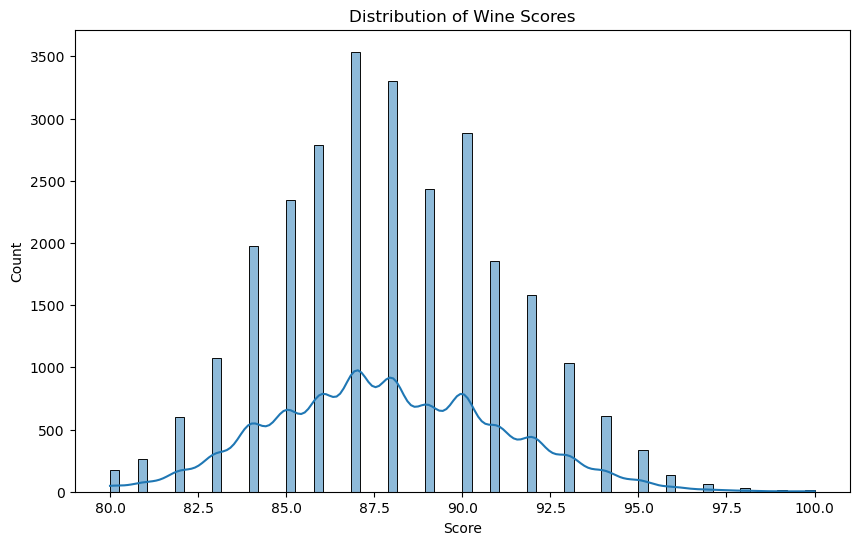

In [41]:
# Histogram of Wine Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['Score'], kde=True)
plt.title('Distribution of Wine Scores')
plt.xlabel('Score')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


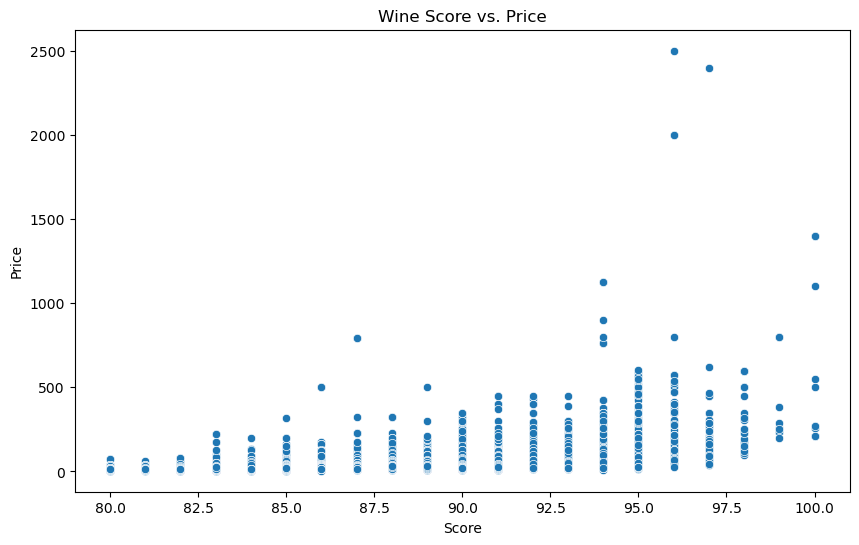

In [42]:
# Scatter plot of Wine Score vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Score', y='Price')
plt.title('Wine Score vs. Price')
plt.xlabel('Score')
plt.ylabel('Price')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


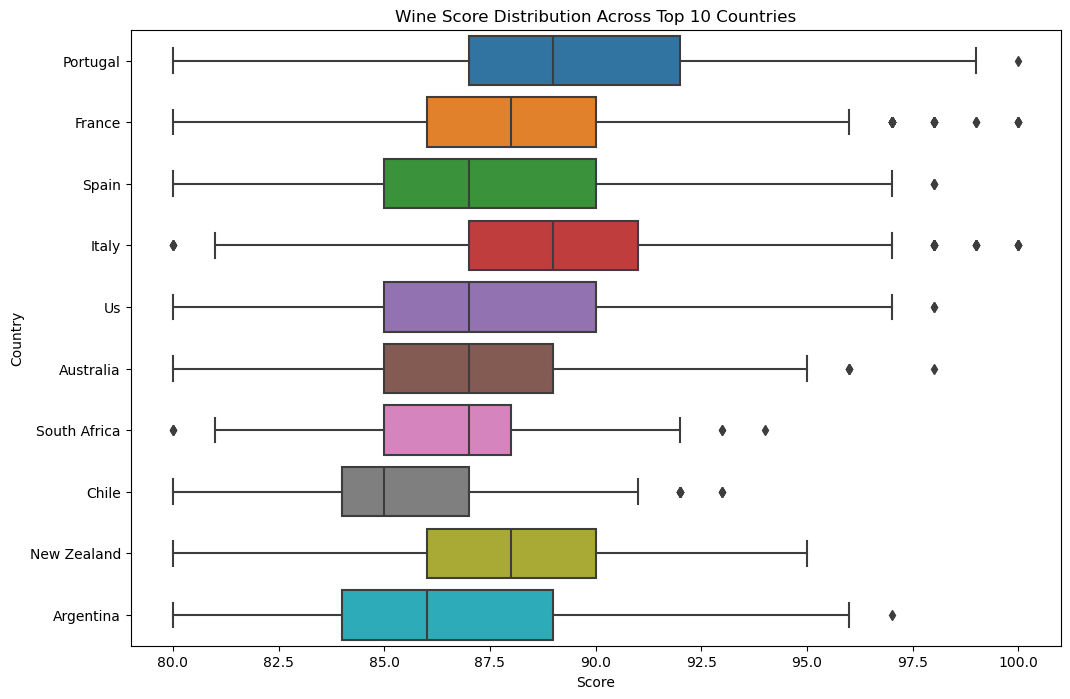

In [43]:
# Selecting the top 10 countries
top_10_countries = df['Country'].value_counts().head(10).index

# Filtering the DataFrame for only the top 10 countries
df_top_countries = df[df['Country'].isin(top_10_countries)]

# Boxplot of Wine Scores across top 10 Countries
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_countries, x='Score', y='Country')
plt.title('Wine Score Distribution Across Top 10 Countries')
plt.xlabel('Score')
plt.ylabel('Country')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


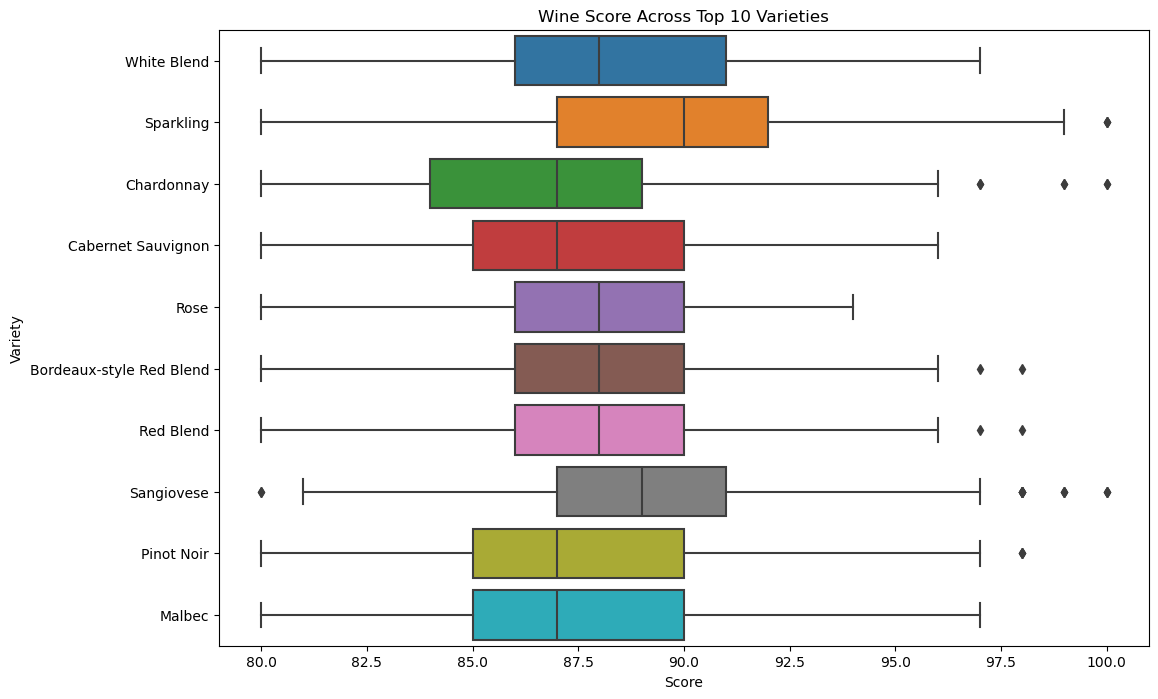

In [44]:
# Boxplot of Wine Scores across top 10 Varieties
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_varieties, x='Score', y='Variety')
plt.title('Wine Score Across Top 10 Varieties')
plt.xlabel('Score')
plt.ylabel('Variety')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


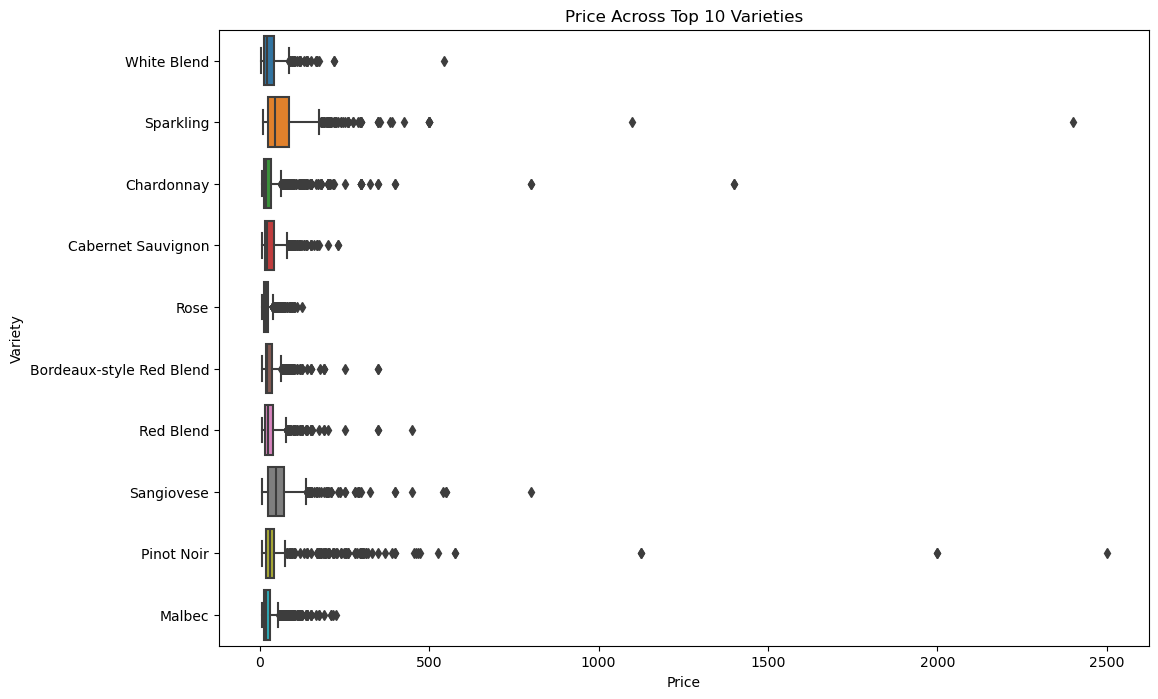

In [45]:
# Boxplot of Price across top 10 Varieties
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_varieties, x='Price', y='Variety')
plt.title('Price Across Top 10 Varieties')
plt.xlabel('Price')
plt.ylabel('Variety')
plt.show()

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


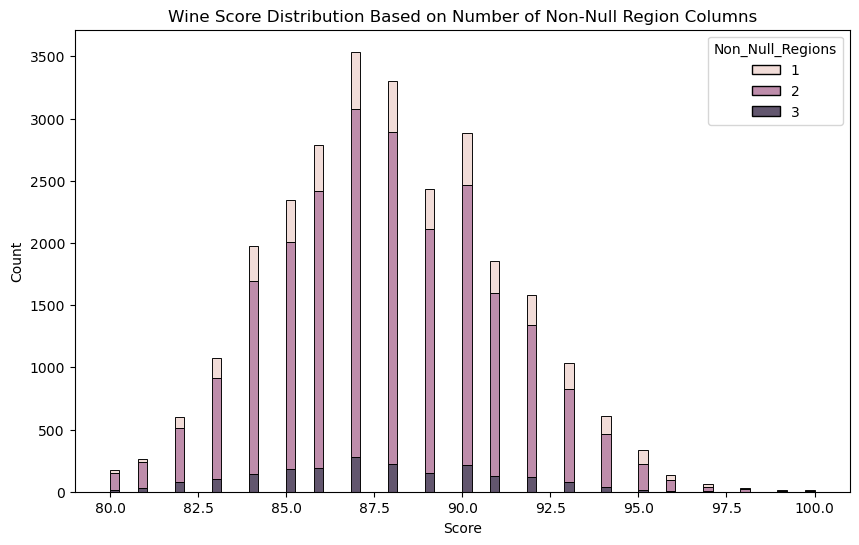

In [46]:
# Counting non-null values in Region columns
region_columns = ['Region 1', 'Region 2', 'Region 3']  # Adjust according to your dataset
df['Non_Null_Regions'] = df[region_columns].notnull().sum(axis=1)

# Plotting distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Score', hue='Non_Null_Regions', multiple='stack')
plt.title('Wine Score Distribution Based on Number of Non-Null Region Columns')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Now we will explore the relationship between wine score and different aspects of wine and weather data.

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-pa

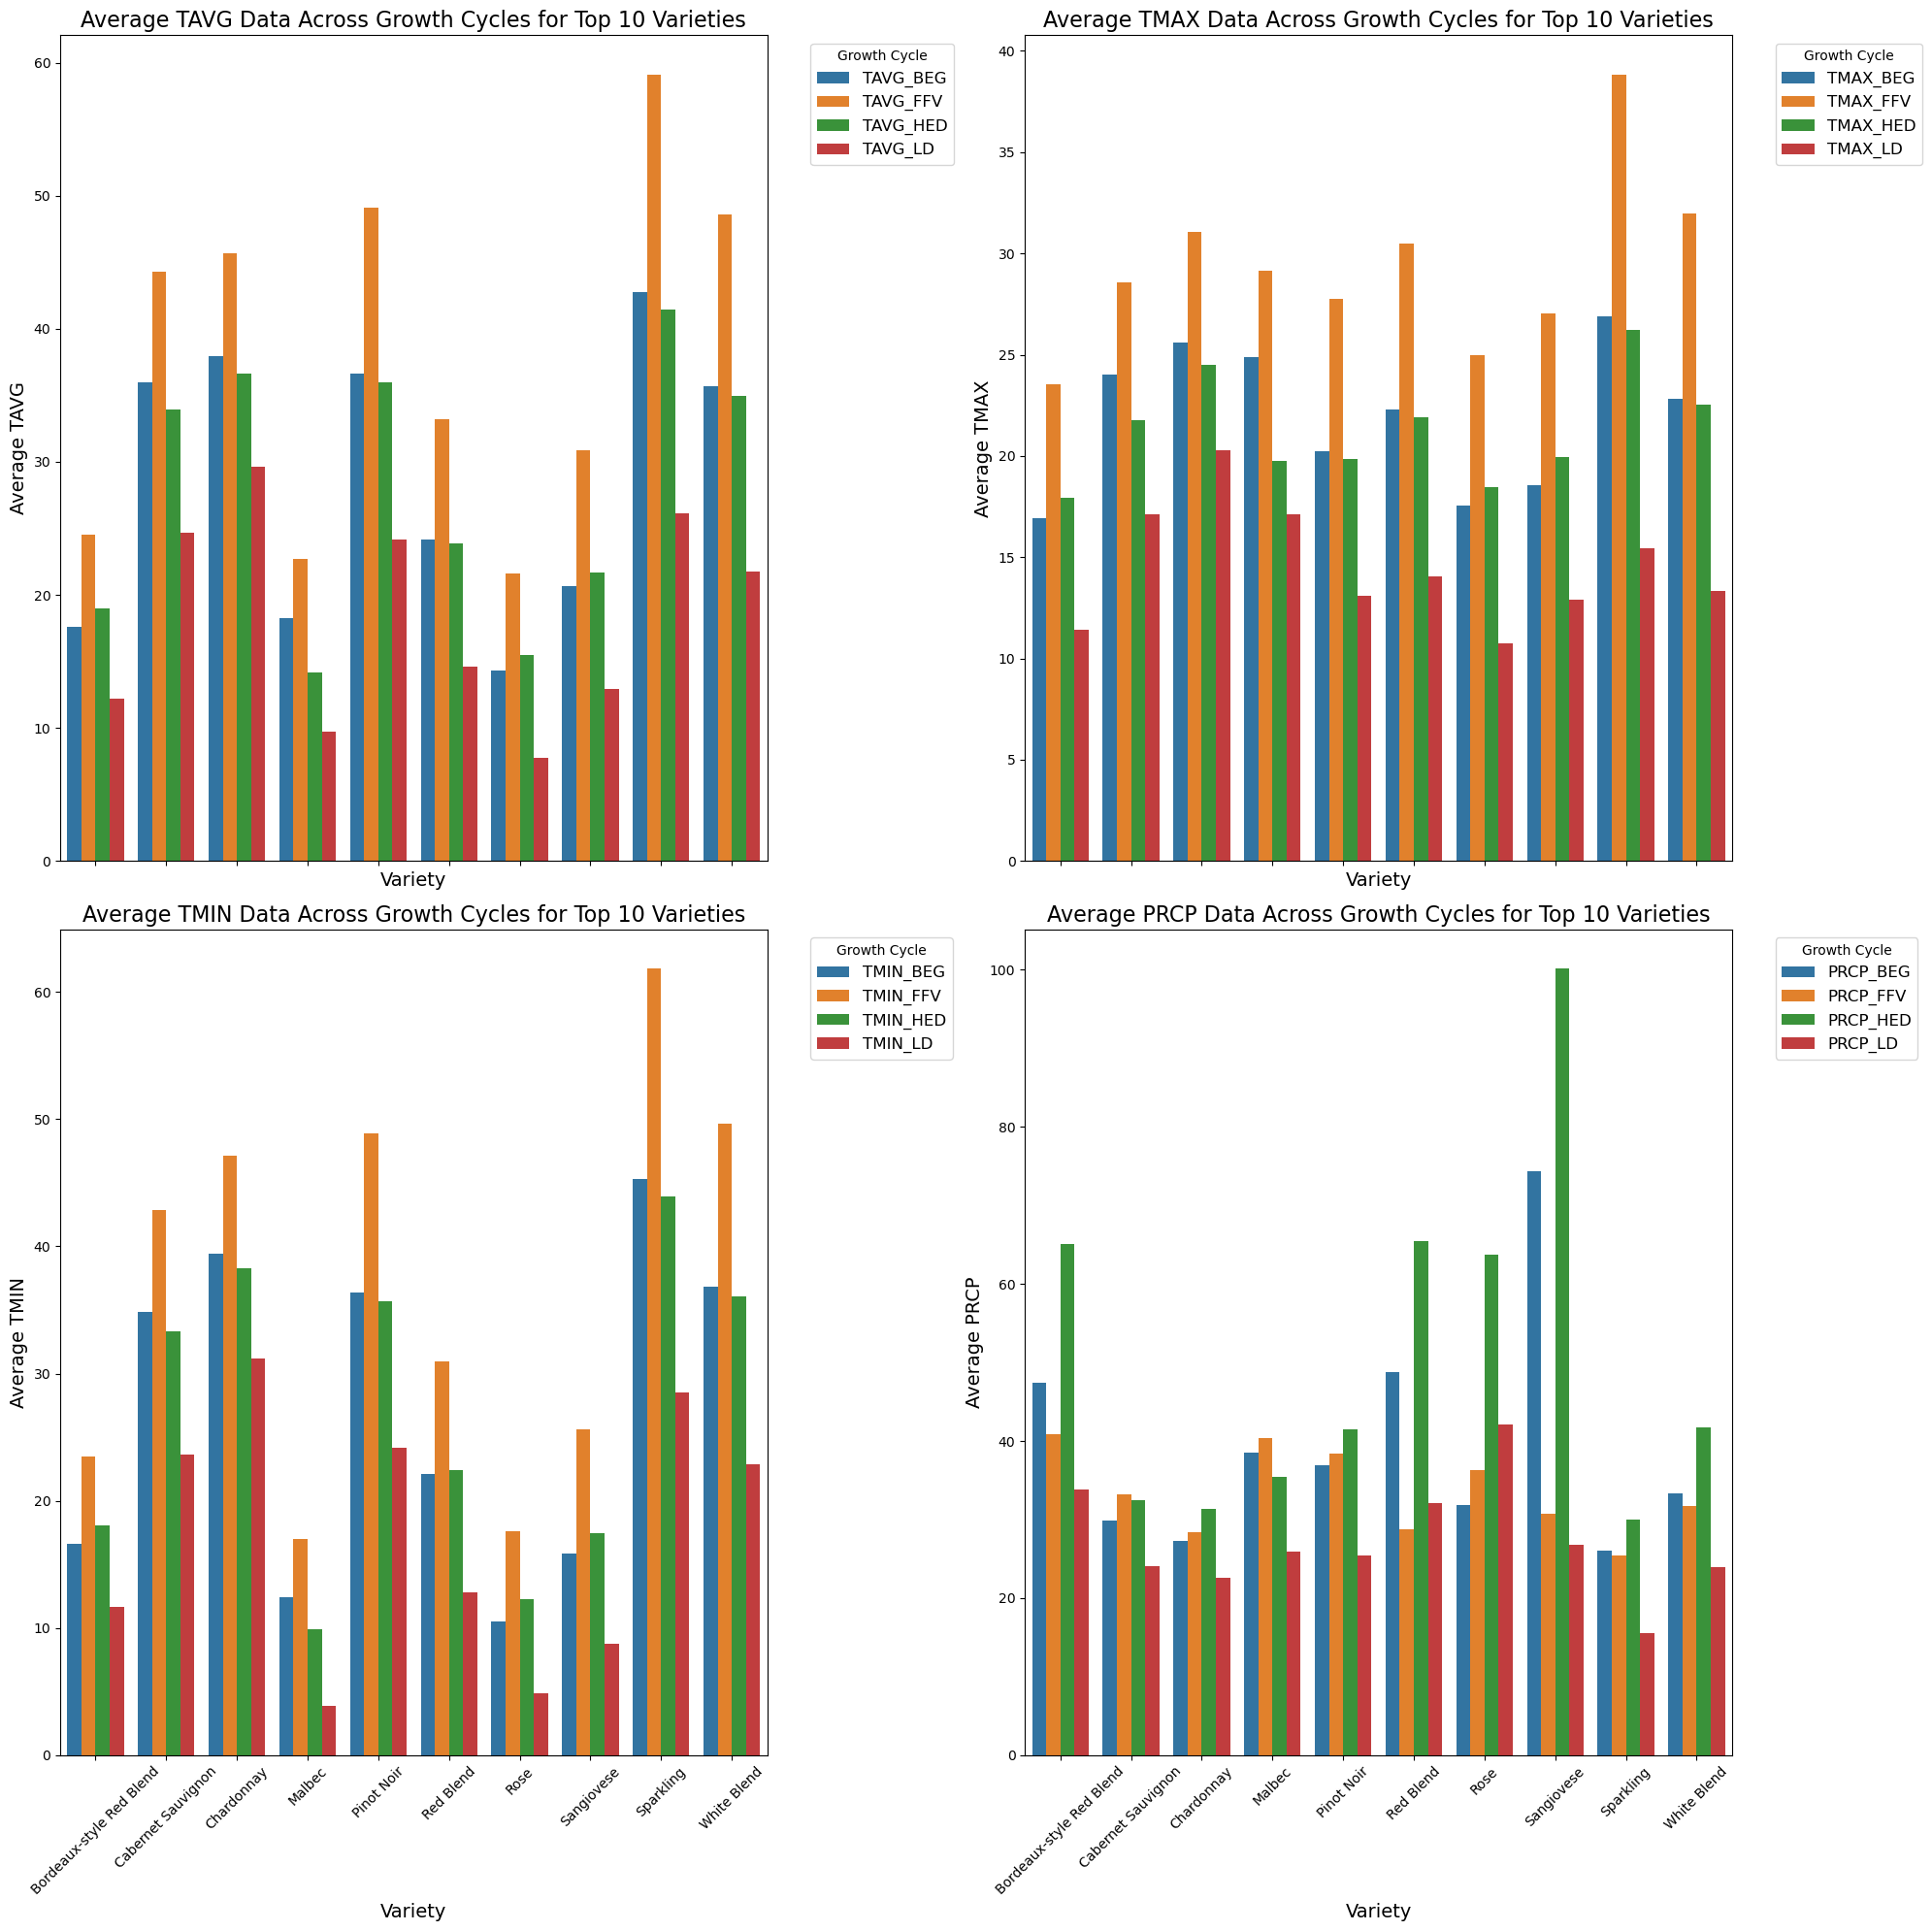

In [47]:
# Filtering the DataFrame for the top 10 varieties
top_10_varieties = df['Variety'].value_counts().head(10).index
df_top_varieties = df[df['Variety'].isin(top_10_varieties)]

# Recalculating the average weather data for the top 10 varieties
average_weather_data_top10 = {}
for cycle in ['BEG', 'FFV', 'HED', 'LD']:
    for weather_type in weather_data_types:
        cycle_weather_cols = [col for col in df_top_varieties.columns if col.startswith(f'{weather_type}_{cycle}')]
        if cycle_weather_cols:
            avg_per_variety = df_top_varieties[cycle_weather_cols + ['Variety']].groupby('Variety').mean().mean(axis=1)
            average_weather_data_top10[f'{weather_type}_{cycle}'] = avg_per_variety

# Convert the averages to a DataFrame for easier plotting
average_weather_df_top10 = pd.DataFrame(average_weather_data_top10)

# Melting the DataFrame for easier plotting
average_weather_melted = average_weather_df_top10.reset_index().melt(id_vars='Variety', var_name='Cycle_Weather', value_name='Average')

# Plotting a matrix of bar plots for each weather data type in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharex=True)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate through each weather data type
for i, weather_type in enumerate(weather_data_types):
    # Filter data for the specific weather type
    weather_cols = [col for col in average_weather_melted['Cycle_Weather'] if weather_type in col]
    filtered_data = average_weather_melted[average_weather_melted['Cycle_Weather'].isin(weather_cols)]
    
    # Create bar plot on the appropriate subplot
    sns.barplot(ax=axes_flat[i], data=filtered_data, x='Variety', y='Average', hue='Cycle_Weather')
    axes_flat[i].set_title(f'Average {weather_type} Data Across Growth Cycles for Top 10 Varieties', fontsize=16)
    axes_flat[i].set_xlabel('Variety', fontsize=14)
    axes_flat[i].set_ylabel(f'Average {weather_type}', fontsize=14)
    axes_flat[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes_flat[i].legend(title='Growth Cycle', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_26896\3957095419.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_weather_data = df.groupby('Score_Bin')[col_name].mean()


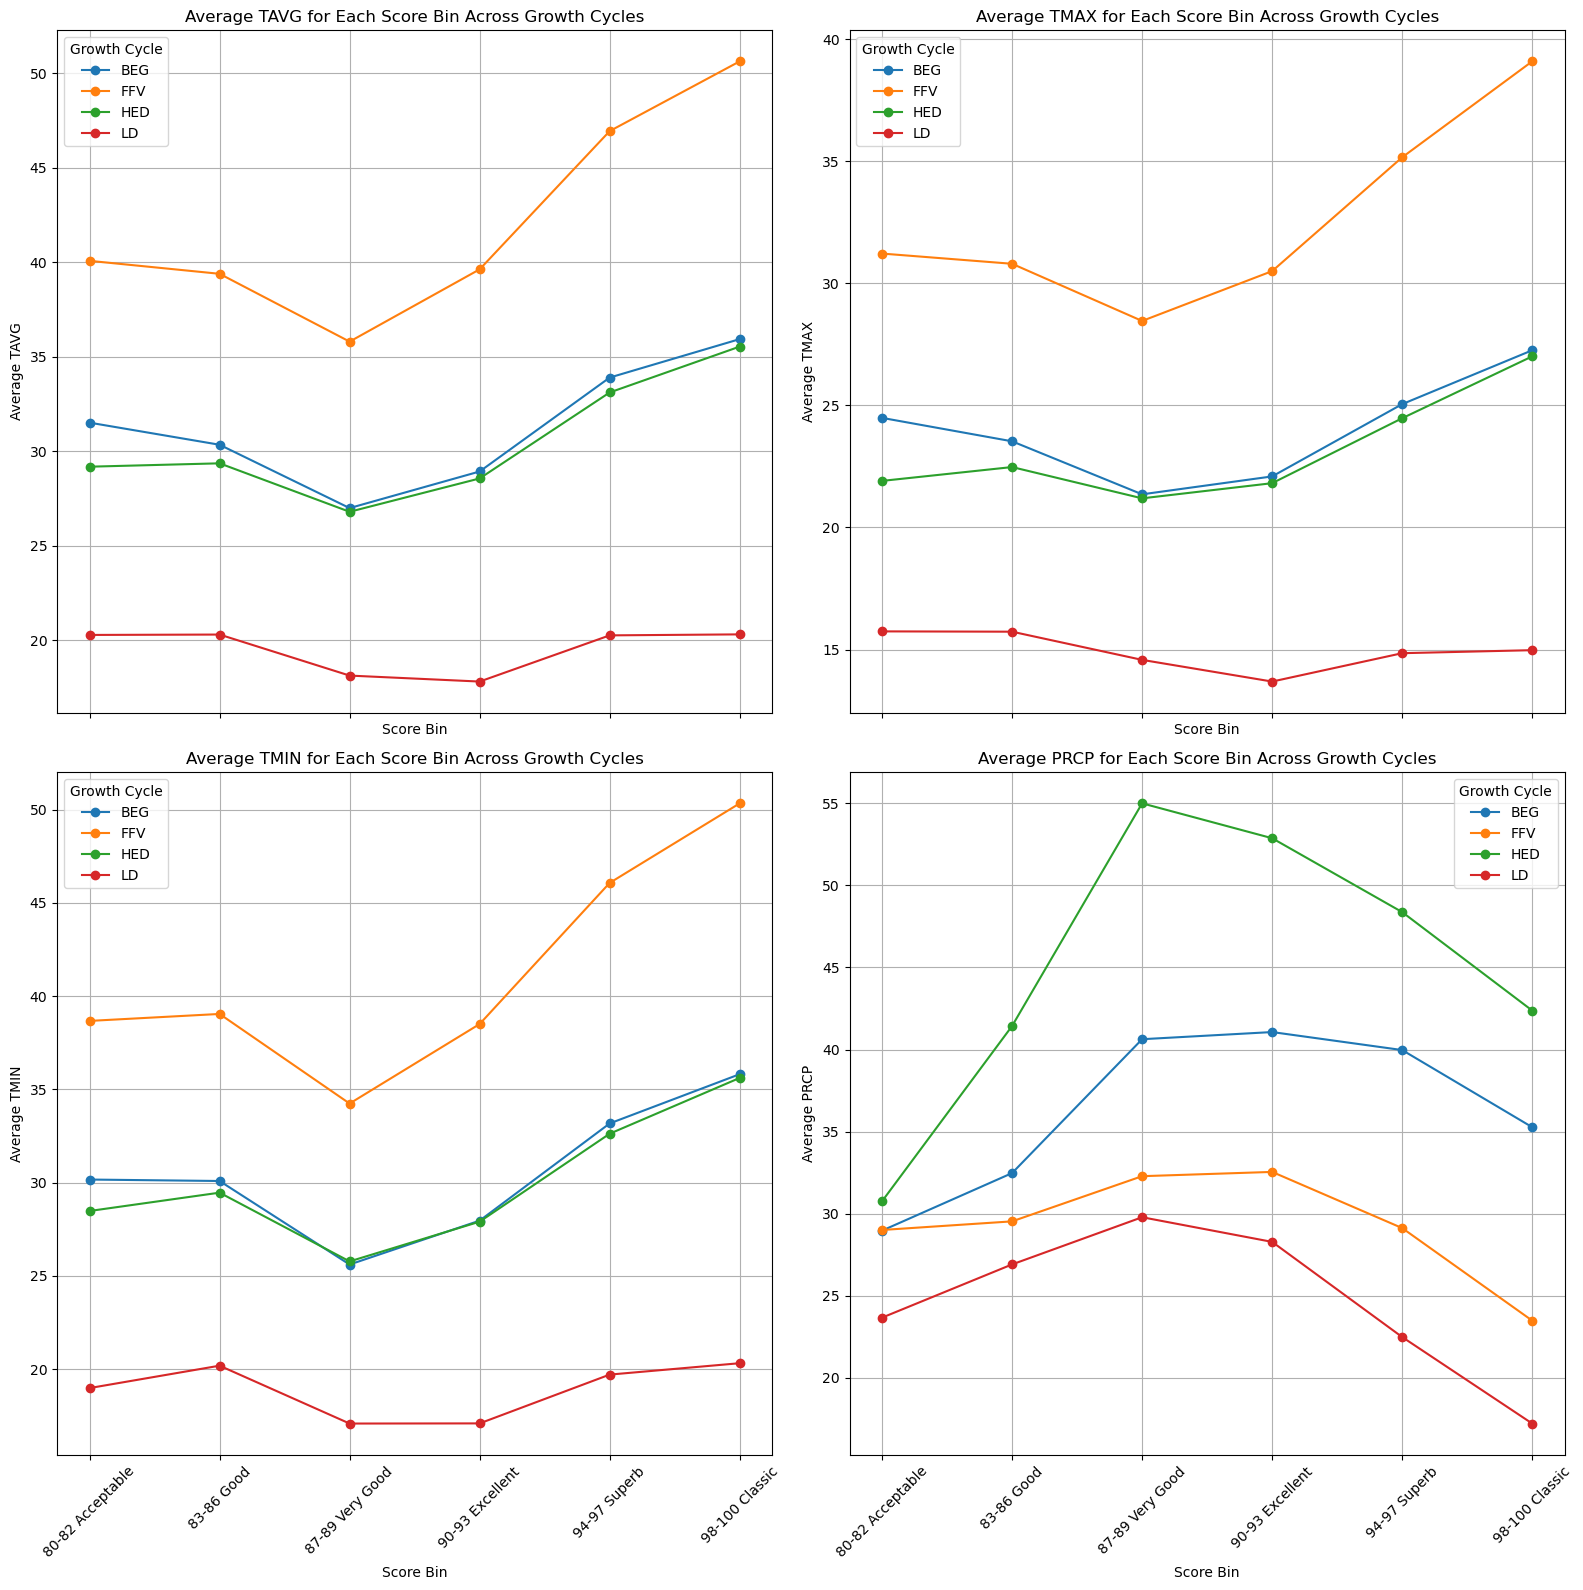

In [48]:
# Define score bins and labels
score_bins = [80, 82, 86, 89, 93, 97, 100]
bin_labels = ['80-82 Acceptable', '83-86 Good', '87-89 Very Good', 
              '90-93 Excellent', '94-97 Superb', '98-100 Classic']

df['Score_Bin'] = pd.cut(df['Score'], bins=score_bins, labels=bin_labels, right=False)

# Calculate the average weather data for each bin
avg_weather_data_per_bin = {}
for weather_type in weather_data_types:
    for cycle in ['BEG', 'FFV', 'HED', 'LD']:
        col_name = f'{weather_type}_{cycle}'
        avg_weather_data = df.groupby('Score_Bin')[col_name].mean()
        avg_weather_data_per_bin[col_name] = avg_weather_data

# Convert to DataFrame
avg_weather_df = pd.DataFrame(avg_weather_data_per_bin)

# Plotting a matrix of line plots for each weather data type in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharex=True)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate through each weather data type
for i, weather_type in enumerate(weather_data_types):
    for cycle in ['BEG', 'FFV', 'HED', 'LD']:
        col_name = f'{weather_type}_{cycle}'
        axes_flat[i].plot(avg_weather_df.index, avg_weather_df[col_name], marker='o', label=cycle)

    axes_flat[i].set_title(f'Average {weather_type} for Each Score Bin Across Growth Cycles')
    axes_flat[i].set_xlabel('Score Bin')
    axes_flat[i].set_ylabel(f'Average {weather_type}')
    axes_flat[i].legend(title='Growth Cycle')
    axes_flat[i].grid(True)
    axes_flat[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Preliminary Statistical Analysis

In [49]:
score_price_correlation = df['Score'].corr(df['Price'])
score_price_correlation

0.43479942850587544

In [50]:
score_distribution = df['Score'].describe()
score_distribution

count    27051.000000
mean        87.894422
std          3.214331
min         80.000000
25%         86.000000
50%         88.000000
75%         90.000000
max        100.000000
Name: Score, dtype: float64

In [51]:
score_dist_country = df.groupby('Country')['Score'].describe()
score_dist_country.to_csv('statistical_outputs/score_dist_country.csv')
score_dist_country

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Argentina,3500.0,86.640857,3.233574,80.0,84.00,86.0,89.0,97.0
Australia,610.0,87.096721,2.921888,80.0,85.00,87.0,89.0,98.0
Austria,226.0,89.548673,3.088304,81.0,87.00,90.0,92.0,97.0
Brazil,1.0,83.000000,NaN,83.0,83.00,83.0,83.0,83.0
Canada,49.0,88.102041,2.931474,83.0,86.00,88.0,90.0,96.0
Chile,619.0,85.663974,2.519859,80.0,84.00,85.0,87.0,93.0
Croatia,5.0,87.400000,0.547723,87.0,87.00,87.0,88.0,88.0
Cyprus,4.0,87.750000,1.892969,85.0,87.25,88.5,89.0,89.0
France,7579.0,88.196596,2.981492,80.0,86.00,88.0,90.0,100.0


In [52]:
score_dist_variety = df.groupby('Variety')['Score'].describe()
score_dist_variety.to_csv('statistical_outputs/score_dist_variety.csv')
score_dist_variety

,count,mean,std,min,25%,50%,75%,max
Variety,,,,,,,,
Abouriou,2.0,89.000000,2.828427,87.0,88.00,89.0,90.00,91.0
Agiorgitiko,3.0,86.666667,1.527525,85.0,86.00,87.0,87.50,88.0
Aglianico,52.0,89.230769,2.601775,83.0,88.00,90.0,91.00,94.0
Albana,6.0,89.666667,3.614784,84.0,87.75,90.5,91.75,94.0
Albarino,26.0,85.807692,1.744001,81.0,85.00,86.0,87.00,88.0
...,...,...,...,...,...,...,...,...
Xinisteri,1.0,89.000000,NaN,89.0,89.00,89.0,89.00,89.0
Xinomavro,2.0,85.000000,2.828427,83.0,84.00,85.0,86.00,87.0
Xynisteri,1.0,85.000000,NaN,85.0,85.00,85.0,85.00,85.0


In [53]:
price_dist_variety = df.groupby('Variety')['Price'].describe()
price_dist_variety.to_csv('statistical_outputs/price_dist_variety.csv')
price_dist_variety

,count,mean,std,min,25%,50%,75%,max
Variety,,,,,,,,
Abouriou,2.0,15.000000,0.000000,15.0,15.00,15.0,15.00,15.0
Agiorgitiko,3.0,29.000000,14.730920,16.0,21.00,26.0,35.50,45.0
Aglianico,33.0,50.606061,28.617018,16.0,32.00,42.0,65.00,130.0
Albana,5.0,31.800000,18.116291,12.0,14.00,35.0,48.00,50.0
Albarino,26.0,17.961538,6.003204,11.0,13.50,17.5,19.00,35.0
...,...,...,...,...,...,...,...,...
Xinisteri,1.0,20.000000,NaN,20.0,20.00,20.0,20.00,20.0
Xinomavro,2.0,25.500000,13.435029,16.0,20.75,25.5,30.25,35.0
Xynisteri,1.0,16.000000,NaN,16.0,16.00,16.0,16.00,16.0


In [54]:
# Filter only numeric columns related to weather data
weather_data_columns = df.columns[df.columns.str.contains('TAVG|TMAX|TMIN|PRCP')]
numeric_df = df[weather_data_columns]

# Group by 'Variety' and calculate the mean of weather data
average_weather_varieties = numeric_df.groupby(df['Variety']).mean()

average_weather_varieties.to_csv('statistical_outputs/average_weather_varieties.csv')
average_weather_varieties

,TAVG_BEG,TMAX_BEG,TMIN_BEG,PRCP_BEG,TAVG_FFV,TMAX_FFV,TMIN_FFV,PRCP_FFV,TAVG_HED,TMAX_HED,TMIN_HED,PRCP_HED,TAVG_LD,TMAX_LD,TMIN_LD,PRCP_LD
Variety,,,,,,,,,,,,,,,,
Abouriou,9.666667,11.900000,8.033333,67.666667,15.780000,18.480000,13.780000,37.560000,13.625000,15.575000,11.850000,90.350000,6.300000,7.950000,4.500000,59.400000
Agiorgitiko,48.771111,37.606667,59.934444,3.490667,66.386222,54.953778,77.853407,3.869778,46.920000,36.232500,57.615000,2.872500,23.888148,14.306667,33.410926,1.837833
Aglianico,44.624693,31.475429,52.337168,11.795071,61.239502,46.070017,69.024254,17.028055,43.357677,30.444490,50.623843,14.601558,21.958935,12.449889,28.430683,6.253524
Albana,14.033333,17.266667,7.633333,85.666667,22.500000,25.400000,15.540000,29.880000,15.725000,19.300000,10.150000,117.700000,9.150000,13.000000,3.650000,29.100000
Albarino,45.167151,32.472525,53.226311,11.467810,63.273753,48.994574,71.753644,10.546909,43.058034,31.239423,50.846621,9.208959,25.190892,15.040353,32.366090,8.011809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xinisteri,50.623333,3.112000,39.310000,61.950000,66.878889,3.403667,55.323778,78.420444,43.252500,2.205000,32.695000,53.797500,29.510000,2.321500,19.450000,39.550000
Xinomavro,48.285231,37.189861,59.387269,3.271269,67.214833,55.410694,78.923611,3.474683,47.875590,36.757500,58.896563,2.560958,25.048333,15.423889,34.619444,1.833861
Xynisteri,16.466667,21.466667,11.466667,28.833333,23.840000,29.100000,18.560000,4.960000,19.675000,24.775000,14.475000,51.550000,11.800000,16.250000,7.250000,73.350000


In [55]:
# Define score bins
score_bins = [80, 82, 86, 89, 93, 97, 100]
bin_labels = ['80-82 Acceptable', '83-86 Good', '87-89 Very Good', 
              '90-93 Excellent', '94-97 Superb', '98-100 Classic']
df['Score_Bin'] = pd.cut(df['Score'], bins=score_bins, labels=bin_labels, right=False)

# Selecting only the relevant weather data columns
weather_data_columns = df.columns[df.columns.str.contains('TAVG|TMAX|TMIN|PRCP')]

# Group by Score Bin and calculate the average weather data
avg_weather_data_per_score_bin = df.groupby('Score_Bin')[weather_data_columns].mean()

avg_weather_data_per_score_bin.to_csv('statistical_outputs/avg_weather_data_per_score_bin.csv')
avg_weather_data_per_score_bin

C:\Users\George Jieh\AppData\Local\Temp\ipykernel_26896\2786121746.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_weather_data_per_score_bin = df.groupby('Score_Bin')[weather_data_columns].mean()


,TAVG_BEG,TMAX_BEG,TMIN_BEG,PRCP_BEG,TAVG_FFV,TMAX_FFV,TMIN_FFV,PRCP_FFV,TAVG_HED,TMAX_HED,TMIN_HED,PRCP_HED,TAVG_LD,TMAX_LD,TMIN_LD,PRCP_LD
Score_Bin,,,,,,,,,,,,,,,,
80-82 Acceptable,31.512406,24.487903,30.162169,28.972255,40.069210,31.216558,38.669129,29.012171,29.183497,21.907461,28.475816,30.759228,20.286498,15.745009,18.979819,23.674242
83-86 Good,30.343880,23.528446,30.084070,32.476063,39.383708,30.798293,39.042237,29.536926,29.361692,22.473867,29.458666,41.432104,20.306953,15.732466,20.180063,26.915742
87-89 Very Good,26.994762,21.357698,25.604332,40.627898,35.797690,28.456947,34.237940,32.287726,26.798845,21.193161,25.771944,54.990208,18.137212,14.577995,17.077401,29.788825
90-93 Excellent,28.930052,22.090945,27.958650,41.063353,39.620003,30.497496,38.501723,32.547976,28.562592,21.813875,27.903519,52.865426,17.821349,13.690271,17.085363,28.286790
94-97 Superb,33.896778,25.050471,33.171456,39.967104,46.929769,35.158569,46.070833,29.128087,33.109140,24.473893,32.620365,48.366932,20.263888,14.851794,19.702194,22.492781
98-100 Classic,35.930289,27.256605,35.812849,35.270504,50.618555,39.087873,50.336984,23.492503,35.534827,27.006733,35.611647,42.371744,20.316396,14.975403,20.313226,17.226485


The results may change down the line, since we are only working with a small percentage of the available and we aren't using a randomized sample. This will be reran once we have a more significant portion of of the dataset ready. Here are the insights we have so far:

## Preliminary Exploratory Data Analysis (EDA) Summary for Wine Data

### Weather Data and Wine Quality

#### 1. Weather Influence on High vs. Low Scoring Wines
- **Observation:** Comparing weather data for high (90+) and lower (<90) scoring wines:
  - **Budburst and Early Growth (BEG):** High scoring wines experience higher average and minimum temperatures, with slightly more total precipitation. For instance, high scorers have an average temperature of 32.92°C and total precipitation of 38.77 mm, compared to 29.62°C and 34.03 mm for lower scorers.
  - **Flowering, Fruit Set, and Veraison (FFV):** High scorers have notably warmer average temperatures (45.72°C vs. 38.42°C) and slightly lower total precipitation (28.39 mm vs. 30.28 mm).
  - **Hypothesis:** Optimal grape development for high-quality wines might require warmer temperatures during the early growth stages and a balance of warm temperatures with controlled water stress during the flowering and fruit set stage.

#### 2. Precipitation and Temperature Patterns Across Growth Stages
- **BEG Stage:** Higher quality wines are associated with a warmer and slightly wetter early growth stage, suggesting the importance of adequate water availability for initial grape development.
- **FFV Stage:** The warmth during this stage is critical, with high scorers showing significantly higher temperatures. The slightly lower precipitation could suggest a need for controlled water stress to concentrate flavors in grapes.

#### 3. Late Dormancy (LD) Weather Impact
- **Analysis:** The similarity in temperatures and precipitation in the LD stage for both high and low scorers (e.g., avg. temperature around 19°C) indicates that this stage may have a lesser impact on the final wine quality compared to earlier stages.

### Top 5 Varieties and Countries: Climate Adaptability
- **Top Varieties:** Port, Champagne Blend, Sangiovese Grosso, Corvina/Rondinella/Molinara, Sagrantino
  - **Climate Preference:** Each of these varieties likely has specific climatic requirements. For instance, Champagne Blend may favor cooler, more temperate climates with consistent precipitation patterns.
- **Top Countries:** Portugal, Austria, Hungary, Italy, New Zealand
  - **Climate-Wine Relationship:** These countries show diverse climatic conditions. For example, Portugal's warm, dry climate is ideal for Port, while Austria's cooler climate suits white wine varieties.

### Statistical Insights
- **Wine Scores and Climate:** The statistical analysis of weather data across score bins indicates that certain temperature and precipitation conditions during key growth stages are more conducive to producing higher-quality wines.
- **Variety-Specific Climate Needs:** Varieties like Sangiovese Grosso and Sagrantino, thriving in specific climatic conditions, might have narrower temperature and precipitation ranges that favor their optimal growth.

### Hypotheses and Further Analysis
- **Hypothesis 1:** Wines from regions with climates that closely match the ideal conditions for their variety (e.g., Champagne in temperate regions) tend to score higher.
- **Hypothesis 2:** Varieties with broader climatic adaptability might show a wider range of scores due to variability in growing conditions across regions.
- **Further Analysis Needed:** A deeper investigation into variety-specific climate requirements and regional climate data would provide more conclusive insights into the optimal conditions for each wine variety.